In [155]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                           precision_recall_fscore_support, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import glob
import json
from datetime import datetime
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import kagglehub

import os
import platform

# Detect if running on Kaggle (no internet)
IS_KAGGLE = os.path.exists("/kaggle") or "KAGGLE_URL_BASE" in os.environ

WANDB_AVAILABLE = False if IS_KAGGLE else True

if WANDB_AVAILABLE:
    import wandb
    wandb.init(project="BreakHis-Classification", name=f"ResNet50-{magnification if magnification else 'all'}")
    logger = {'type': 'wandb', 'logger': wandb}
else:
    logger = None

try:
    from torch.utils.tensorboard import SummaryWriter
    TENSORBOARD_AVAILABLE = True
except ImportError:
    TENSORBOARD_AVAILABLE = False
    print("tensorboard not available. Install with: pip install tensorboard")


In [156]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [157]:
# Download dataset
path = kagglehub.dataset_download("ambarish/breakhis")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/breakhis


In [158]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Label Smoothing Cross Entropy Loss"""
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1. - self.smoothing
        log_probs = torch.log_softmax(pred, dim=1)
        nll_loss = -log_probs.gather(dim=1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [159]:
class RandAugment:
    """RandAugment implementation"""
    def __init__(self, n=2, m=10):
        self.n = n
        self.m = m
        self.augmentations = [
            self.auto_contrast,
            self.equalize,
            self.rotate,
            self.solarize,
            self.color,
            self.posterize,
            self.contrast,
            self.brightness,
            self.sharpness,
            self.shear_x,
            self.shear_y,
            self.translate_x,
            self.translate_y,
        ]

    def __call__(self, img):
        ops = np.random.choice(self.augmentations, self.n, replace=False)
        for op in ops:
            img = op(img)
        return img

    def auto_contrast(self, img):
        return transforms.functional.autocontrast(img)

    def equalize(self, img):
        return transforms.functional.equalize(img)

    def rotate(self, img):
        angle = (self.m / 30) * 30 * np.random.choice([-1, 1])
        return transforms.functional.rotate(img, angle)

    def solarize(self, img):
        return transforms.functional.solarize(img, int(256 * (1 - self.m / 10)))

    def color(self, img):
        factor = 1 + (self.m / 10) * np.random.choice([-1, 1])
        return transforms.functional.adjust_saturation(img, factor)

    def posterize(self, img):
        bits = int(8 - (self.m / 10) * 4)
        return transforms.functional.posterize(img, bits)

    def contrast(self, img):
        factor = 1 + (self.m / 10) * np.random.choice([-1, 1])
        return transforms.functional.adjust_contrast(img, factor)

    def brightness(self, img):
        factor = 1 + (self.m / 10) * np.random.choice([-1, 1])
        return transforms.functional.adjust_brightness(img, factor)

    def sharpness(self, img):
        factor = 1 + (self.m / 10) * np.random.choice([-1, 1])
        return transforms.functional.adjust_sharpness(img, factor)

    def shear_x(self, img):
        shear = (self.m / 10) * 0.3 * np.random.choice([-1, 1])
        return transforms.functional.affine(img, angle=0, translate=(0, 0), scale=1, shear=(shear, 0))

    def shear_y(self, img):
        shear = (self.m / 10) * 0.3 * np.random.choice([-1, 1])
        return transforms.functional.affine(img, angle=0, translate=(0, 0), scale=1, shear=(0, shear))

    def translate_x(self, img):
        translate = int((self.m / 10) * 0.3 * img.size[0]) * np.random.choice([-1, 1])
        return transforms.functional.affine(img, angle=0, translate=(translate, 0), scale=1, shear=(0, 0))

    def translate_y(self, img):
        translate = int((self.m / 10) * 0.3 * img.size[1]) * np.random.choice([-1, 1])
        return transforms.functional.affine(img, angle=0, translate=(0, translate), scale=1, shear=(0, 0))


In [160]:
class BreaKHisDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [161]:
def load_dataset(dataset_path):
    """Load and organize the BreaKHis dataset"""
    image_paths = []
    labels = []
    magnifications = []
    patient_ids = []

    # Use glob to find all PNG files recursively
    breast_img_paths = glob.glob(os.path.join(dataset_path, 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png'), recursive=True)

    print(f"Found {len(breast_img_paths)} image files")

    for img_path in breast_img_paths:
        try:
            # Extract information from path
            path_parts = img_path.split(os.sep)

            # Find benign/malignant classification from path
            if 'benign' in img_path.lower():
                label = 0  # benign
            elif 'malignant' in img_path.lower():
                label = 1  # malignant
            else:
                continue

            # Extract filename for further processing
            filename = os.path.basename(img_path)

            # Extract magnification from filename (format: SOB_B_A-14-22549AB-40-001.png)
            if '-40-' in filename:
                mag = '40X'
            elif '-100-' in filename:
                mag = '100X'
            elif '-200-' in filename:
                mag = '200X'
            elif '-400-' in filename:
                mag = '400X'
            else:
                continue

            # Extract patient ID from filename (format: SOB_B_A-14-22549AB-40-001.png)
            # Patient ID is the part before the magnification
            parts = filename.split('-')
            if len(parts) >= 3:
                patient_id = '-'.join(parts[:3])  # SOB_B_A-14-22549AB
            else:
                patient_id = filename.split('.')[0]

            image_paths.append(img_path)
            labels.append(label)
            magnifications.append(mag)
            patient_ids.append(patient_id)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels,
        'magnification': magnifications,
        'patient_id': patient_ids
    })

    print(f"Successfully loaded {len(df)} images")
    print(f"Benign: {len(df[df['label'] == 0])}, Malignant: {len(df[df['label'] == 1])}")

    return df

In [162]:
def create_patient_level_split(df, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """Split dataset at patient level to avoid data leakage"""
    unique_patients = df['patient_id'].unique()

    # Split patients first
    train_patients, temp_patients = train_test_split(
        unique_patients, test_size=(val_ratio + test_ratio), random_state=42, stratify=None
    )
    val_patients, test_patients = train_test_split(
        temp_patients, test_size=test_ratio/(val_ratio + test_ratio), random_state=42, stratify=None
    )

    # Create splits ensuring no patient overlap
    train_df = df[df['patient_id'].isin(train_patients)].copy()
    val_df = df[df['patient_id'].isin(val_patients)].copy()
    test_df = df[df['patient_id'].isin(test_patients)].copy()

    # Verify no patient overlap
    train_patients_set = set(train_df['patient_id'].unique())
    val_patients_set = set(val_df['patient_id'].unique())
    test_patients_set = set(test_df['patient_id'].unique())

    assert len(train_patients_set.intersection(val_patients_set)) == 0, "Patient overlap between train and val"
    assert len(train_patients_set.intersection(test_patients_set)) == 0, "Patient overlap between train and test"
    assert len(val_patients_set.intersection(test_patients_set)) == 0, "Patient overlap between val and test"

    print(f"Patient-level split verified:")
    print(f"Train patients: {len(train_patients_set)}")
    print(f"Val patients: {len(val_patients_set)}")
    print(f"Test patients: {len(test_patients_set)}")

    return train_df, val_df, test_df

In [163]:
def get_transforms():
    """Define improved data augmentation and preprocessing transforms with RandAugment"""

    # Training transforms with RandAugment
    train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        RandAugment(n=2, m=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation/Test transforms (no augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # TTA transforms for test time augmentation
    tta_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_transforms, tta_transforms


In [164]:
def create_balanced_sampler(labels):
    """Create weighted sampler for handling class imbalance"""
    class_counts = Counter(labels)
    class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in labels]

    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )


In [165]:
import torch
import torch.nn as nn
from torchvision import models

def create_resnet_model(num_classes=2, dropout_rate=0.5):
    model = models.resnet50(weights=None)  # Avoid internet download
    weight_path = "/kaggle/input/resnet50-weights/resnet50-0676ba61.pth"
    state_dict = torch.load(weight_path)
    model.load_state_dict(state_dict)

    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify classifier
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(512, num_classes)
    )

    return model


In [166]:
def set_differential_learning_rates(model, base_lr=1e-4):
    """Set different learning rates for different layer groups"""
    parameters = [
        {'params': model.conv1.parameters(), 'lr': base_lr * 0.1},
        {'params': model.bn1.parameters(), 'lr': base_lr * 0.1},
        {'params': model.layer1.parameters(), 'lr': base_lr * 0.2},
        {'params': model.layer2.parameters(), 'lr': base_lr * 0.4},
        {'params': model.layer3.parameters(), 'lr': base_lr * 0.8},
        {'params': model.layer4.parameters(), 'lr': base_lr},
        {'params': model.fc.parameters(), 'lr': base_lr * 2},
    ]
    return parameters

In [167]:
def unfreeze_layers(model, epoch):
    """Gradually unfreeze layers"""
    if epoch >= 5:
        # Unfreeze layer4 and layer3
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.layer3.parameters():
            param.requires_grad = True

    if epoch >= 10:
        # Unfreeze layer2 and layer1
        for param in model.layer2.parameters():
            param.requires_grad = True
        for param in model.layer1.parameters():
            param.requires_grad = True
        for param in model.conv1.parameters():
            param.requires_grad = True
        for param in model.bn1.parameters():
            param.requires_grad = True

In [168]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=1e-4,
                use_mixed_precision=True, logger=None, magnification=None, save_dir='./models/'):
    """Enhanced training with differential learning rates and gradual unfreezing"""

    os.makedirs(save_dir, exist_ok=True)
    model_name = f"resnet50_{magnification if magnification else 'all'}.pth"
    best_model_path = os.path.join(save_dir, f"best_{model_name}")

    model = model.to(device)

    # Loss function with label smoothing
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

    # Optimizer with differential learning rates
    param_groups = set_differential_learning_rates(model, learning_rate)
    optimizer = optim.AdamW(param_groups, weight_decay=0.01)

    # Cosine Annealing Warm Restarts scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )

    # Mixed precision training
    if use_mixed_precision and torch.cuda.is_available():
        scaler = torch.cuda.amp.GradScaler()
    else:
        scaler = None

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_f1_scores = []

    best_val_f1 = 0.0
    patience = 15
    patience_counter = 0

    for epoch in range(num_epochs):
        # Gradual unfreezing
        unfreeze_layers(model, epoch)

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * train_correct / train_total:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)

                if scaler:
                    with torch.cuda.amp.autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100 * val_correct / val_total:.2f}%'
                })

        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        # Calculate F1 score
        _, _, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)

        # Log to wandb or tensorboard
        if logger and logger['type'] == 'wandb':
            logger['logger'].log({
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'lr': optimizer.param_groups[0]['lr']
            })
        elif logger and logger['type'] == 'tensorboard':
            logger['logger'].add_scalar('Loss/Train', train_loss, epoch)
            logger['logger'].add_scalar('Loss/Val', val_loss, epoch)
            logger['logger'].add_scalar('Accuracy/Train', train_acc, epoch)
            logger['logger'].add_scalar('Accuracy/Val', val_acc, epoch)
            logger['logger'].add_scalar('F1/Val', val_f1, epoch)
            logger['logger'].add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)

        # Step scheduler
        scheduler.step()

        # Early stopping based on validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with F1: {best_val_f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return model, train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores

In [169]:
def test_time_augmentation(model, dataset, num_augmentations=5):
    """Perform test time augmentation"""
    model.eval()

    # Get original transform
    original_transform = dataset.transform

    # TTA transforms
    _, _, tta_transforms = get_transforms()

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc='TTA Evaluation'):
            image_path = dataset.image_paths[idx]
            label = dataset.labels[idx]

            # Load image
            image = Image.open(image_path).convert('RGB')

            # Collect predictions from multiple augmentations
            aug_predictions = []
            aug_probabilities = []

            for _ in range(num_augmentations):
                # Apply TTA transform
                augmented_image = tta_transforms(image)
                augmented_image = augmented_image.unsqueeze(0).to(device)

                # Get prediction
                outputs = model(augmented_image)
                probabilities = torch.softmax(outputs, dim=1)

                aug_predictions.append(outputs.cpu().numpy())
                aug_probabilities.append(probabilities.cpu().numpy())

            # Average predictions
            avg_outputs = np.mean(aug_predictions, axis=0)
            avg_probabilities = np.mean(aug_probabilities, axis=0)

            predicted = np.argmax(avg_outputs, axis=1)[0]

            all_predictions.append(predicted)
            all_labels.append(label)
            all_probabilities.append(avg_probabilities[0][1])  # Probability of malignant class

    return all_labels, all_predictions, all_probabilities


In [170]:
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate comprehensive metrics including specificity and AUC-ROC"""
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    # Confusion matrix for specificity calculation
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # AUC-ROC (if probabilities provided)
    auc_roc = None
    if y_pred_proba is not None:
        auc_roc = roc_auc_score(y_true, y_pred_proba)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

In [171]:
def evaluate_model(model, test_loader, class_names=['Benign', 'Malignant'], use_tta=True):
    """Evaluate model with optional TTA"""
    if use_tta:
        print("Performing Test Time Augmentation...")
        all_labels, all_predictions, all_probabilities = test_time_augmentation(
            model, test_loader.dataset, num_augmentations=5
        )
    else:
        model.eval()
        all_predictions = []
        all_labels = []
        all_probabilities = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc='Evaluating'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probabilities.extend(probabilities[:, 1].cpu().numpy())

    # Calculate comprehensive metrics
    metrics = calculate_metrics(all_labels, all_predictions, all_probabilities)

    # Classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names)

    metrics['classification_report'] = report
    metrics['predictions'] = all_predictions
    metrics['labels'] = all_labels
    metrics['probabilities'] = all_probabilities

    return metrics


In [172]:
def plot_confusion_matrix(cm, class_names, title, save_path=None):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [173]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,
                        val_f1_scores=None, save_path=None):
    """Plot training and validation curves"""
    fig, axes = plt.subplots(1, 3 if val_f1_scores else 2, figsize=(20, 5))

    # Loss curves
    axes[0].plot(train_losses, label='Training Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy curves
    axes[1].plot(train_accuracies, label='Training Accuracy')
    axes[1].plot(val_accuracies, label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    # F1 score curves
    if val_f1_scores:
        axes[2].plot(val_f1_scores, label='Validation F1 Score', color='green')
        axes[2].set_title('Validation F1 Score')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('F1 Score')
        axes[2].legend()
        axes[2].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [174]:
def plot_roc_curve(labels, probabilities, title='ROC Curve', save_path=None):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(labels, probabilities)
    auc_score = roc_auc_score(labels, probabilities)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [175]:
def print_detailed_metrics(metrics, title="Model Evaluation Metrics"):
    print("\n" + "="*80)
    print(f"{title}")
    print("="*80)
    for key in ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'auc_roc']:
        print(f"{key.capitalize():<15}: {metrics[key]:.4f}")
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    print(f"\nTrue Positives (TP): {metrics['tp']}, True Negatives (TN): {metrics['tn']}\nFalse Positives (FP): {metrics['fp']}, False Negatives (FN): {metrics['fn']}")
    print("\nClassification Report:")
    print(metrics['classification_report'])
    print("="*80 + "\n")

In [176]:
def run_experiment(df, magnification=None, base_save_dir="./models_breakhis"):
    if magnification:
        df = df[df['magnification'] == magnification]
        print(f"\n--- Training on {magnification} images ---")
    else:
        print("\n--- Training on ALL magnifications ---")

    train_df, val_df, test_df = create_patient_level_split(df)
    train_transforms, val_transforms, _ = get_transforms()

    train_dataset = BreaKHisDataset(train_df['image_path'].tolist(), train_df['label'].tolist(), transform=train_transforms)
    val_dataset   = BreaKHisDataset(val_df['image_path'].tolist(), val_df['label'].tolist(), transform=val_transforms)
    test_dataset  = BreaKHisDataset(test_df['image_path'].tolist(), test_df['label'].tolist(), transform=val_transforms)

    sampler = create_balanced_sampler(train_df['label'].tolist())
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    model = create_resnet_model(num_classes=2)

    logger = None
    if WANDB_AVAILABLE:
        wandb.init(project="BreakHis-Classification", name=f"ResNet50-{magnification if magnification else 'all'}")
        logger = {'type': 'wandb', 'logger': wandb}
    elif TENSORBOARD_AVAILABLE:
        log_dir = os.path.join("./runs", datetime.now().strftime("%Y%m%d-%H%M%S") + f"_{magnification if magnification else 'all'}")
        tb_writer = SummaryWriter(log_dir=log_dir)
        logger = {'type': 'tensorboard', 'logger': tb_writer}

    model, train_losses, val_losses, train_accs, val_accs, val_f1s = train_model(
        model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4,
        use_mixed_precision=True, logger=logger, magnification=magnification, save_dir=base_save_dir
    )

    # Load best model
    model.load_state_dict(torch.load(os.path.join(base_save_dir, f"best_resnet50_{magnification if magnification else 'all'}.pth")))

    # Evaluate model
    metrics = evaluate_model(model, test_loader, use_tta=True)
    print_detailed_metrics(metrics, title=f"Evaluation on {magnification if magnification else 'All'} Magnification")

    # Plot confusion matrix & ROC
    plot_confusion_matrix(metrics['confusion_matrix'], ['Benign', 'Malignant'], f"Confusion Matrix ({magnification})")
    plot_roc_curve(metrics['labels'], metrics['probabilities'], title=f"ROC Curve ({magnification})")

    # Plot training curves
    plot_training_curves(train_losses, val_losses, train_accs, val_accs, val_f1s)

    return metrics


Found 7909 image files
Successfully loaded 7909 images
Benign: 2480, Malignant: 5429

--- Training on 40X images ---
Patient-level split verified:
Train patients: 57
Val patients: 16
Test patients: 9


Epoch 1/50 [Val]: 100%|██████████| 15/15 [00:04<00:00,  3.14it/s, Loss=0.6355, Acc=86.27%]


Epoch 1/50:
Train Loss: 0.6891, Train Acc: 55.99%
Val Loss: 0.5500, Val Acc: 86.27%, Val F1: 0.9029
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9029


Epoch 2/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s, Loss=0.4258, Acc=88.67%]


Epoch 2/50:
Train Loss: 0.6361, Train Acc: 65.13%
Val Loss: 0.4811, Val Acc: 88.67%, Val F1: 0.9242
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9242


Epoch 3/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s, Loss=0.7621, Acc=67.10%]


Epoch 3/50:
Train Loss: 0.6329, Train Acc: 66.28%
Val Loss: 0.5952, Val Acc: 67.10%, Val F1: 0.7219
Current LR: 0.000009
--------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s, Loss=0.4206, Acc=89.98%]


Epoch 4/50:
Train Loss: 0.6165, Train Acc: 67.28%
Val Loss: 0.4511, Val Acc: 89.98%, Val F1: 0.9333
Current LR: 0.000008
--------------------------------------------------
New best model saved with F1: 0.9333


Epoch 5/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s, Loss=0.3681, Acc=89.98%]


Epoch 5/50:
Train Loss: 0.6119, Train Acc: 66.28%
Val Loss: 0.4278, Val Acc: 89.98%, Val F1: 0.9345
Current LR: 0.000007
--------------------------------------------------
New best model saved with F1: 0.9345


Epoch 6/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.61it/s, Loss=0.3394, Acc=83.22%]


Epoch 6/50:
Train Loss: 0.5761, Train Acc: 70.89%
Val Loss: 0.4312, Val Acc: 83.22%, Val F1: 0.8776
Current LR: 0.000005
--------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.61it/s, Loss=0.2773, Acc=90.85%]


Epoch 7/50:
Train Loss: 0.4842, Train Acc: 78.03%
Val Loss: 0.3428, Val Acc: 90.85%, Val F1: 0.9356
Current LR: 0.000004
--------------------------------------------------
New best model saved with F1: 0.9356


Epoch 8/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s, Loss=0.2830, Acc=89.11%]


Epoch 8/50:
Train Loss: 0.4644, Train Acc: 81.34%
Val Loss: 0.3587, Val Acc: 89.11%, Val F1: 0.9219
Current LR: 0.000003
--------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s, Loss=0.2658, Acc=94.12%]


Epoch 9/50:
Train Loss: 0.4670, Train Acc: 79.11%
Val Loss: 0.3141, Val Acc: 94.12%, Val F1: 0.9595
Current LR: 0.000002
--------------------------------------------------
New best model saved with F1: 0.9595


Epoch 10/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s, Loss=0.2669, Acc=93.25%]


Epoch 10/50:
Train Loss: 0.4294, Train Acc: 82.95%
Val Loss: 0.3229, Val Acc: 93.25%, Val F1: 0.9543
Current LR: 0.000001
--------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s, Loss=0.2143, Acc=94.55%]


Epoch 11/50:
Train Loss: 0.4764, Train Acc: 79.34%
Val Loss: 0.3058, Val Acc: 94.55%, Val F1: 0.9631
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9631


Epoch 12/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s, Loss=0.2218, Acc=92.37%]


Epoch 12/50:
Train Loss: 0.4506, Train Acc: 80.88%
Val Loss: 0.3668, Val Acc: 92.37%, Val F1: 0.9495
Current LR: 0.000010
--------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s, Loss=0.2168, Acc=92.81%]


Epoch 13/50:
Train Loss: 0.4377, Train Acc: 82.49%
Val Loss: 0.3220, Val Acc: 92.81%, Val F1: 0.9508
Current LR: 0.000010
--------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s, Loss=0.3296, Acc=93.46%]


Epoch 14/50:
Train Loss: 0.4140, Train Acc: 82.95%
Val Loss: 0.3221, Val Acc: 93.46%, Val F1: 0.9545
Current LR: 0.000010
--------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s, Loss=0.2252, Acc=89.11%]


Epoch 15/50:
Train Loss: 0.4054, Train Acc: 85.18%
Val Loss: 0.3749, Val Acc: 89.11%, Val F1: 0.9300
Current LR: 0.000009
--------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s, Loss=0.2232, Acc=91.29%]


Epoch 16/50:
Train Loss: 0.4138, Train Acc: 83.87%
Val Loss: 0.3160, Val Acc: 91.29%, Val F1: 0.9405
Current LR: 0.000009
--------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s, Loss=0.2069, Acc=92.16%]


Epoch 17/50:
Train Loss: 0.3929, Train Acc: 85.87%
Val Loss: 0.3158, Val Acc: 92.16%, Val F1: 0.9480
Current LR: 0.000008
--------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s, Loss=0.2102, Acc=97.17%]


Epoch 18/50:
Train Loss: 0.3829, Train Acc: 85.48%
Val Loss: 0.2590, Val Acc: 97.17%, Val F1: 0.9807
Current LR: 0.000008
--------------------------------------------------
New best model saved with F1: 0.9807


Epoch 19/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s, Loss=0.2116, Acc=92.16%]


Epoch 19/50:
Train Loss: 0.3997, Train Acc: 84.49%
Val Loss: 0.3028, Val Acc: 92.16%, Val F1: 0.9483
Current LR: 0.000007
--------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s, Loss=0.2059, Acc=96.73%]


Epoch 20/50:
Train Loss: 0.3757, Train Acc: 85.56%
Val Loss: 0.2763, Val Acc: 96.73%, Val F1: 0.9781
Current LR: 0.000006
--------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s, Loss=0.2082, Acc=96.51%]


Epoch 21/50:
Train Loss: 0.3761, Train Acc: 85.64%
Val Loss: 0.2621, Val Acc: 96.51%, Val F1: 0.9765
Current LR: 0.000005
--------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s, Loss=0.2095, Acc=96.30%]


Epoch 22/50:
Train Loss: 0.3627, Train Acc: 87.48%
Val Loss: 0.2697, Val Acc: 96.30%, Val F1: 0.9750
Current LR: 0.000005
--------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s, Loss=0.2103, Acc=97.17%]


Epoch 23/50:
Train Loss: 0.3464, Train Acc: 88.63%
Val Loss: 0.2667, Val Acc: 97.17%, Val F1: 0.9807
Current LR: 0.000004
--------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s, Loss=0.2059, Acc=95.42%]


Epoch 24/50:
Train Loss: 0.3572, Train Acc: 87.10%
Val Loss: 0.2780, Val Acc: 95.42%, Val F1: 0.9691
Current LR: 0.000003
--------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s, Loss=0.2110, Acc=96.95%]


Epoch 25/50:
Train Loss: 0.3426, Train Acc: 88.94%
Val Loss: 0.2618, Val Acc: 96.95%, Val F1: 0.9793
Current LR: 0.000003
--------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.58it/s, Loss=0.2066, Acc=96.95%]


Epoch 26/50:
Train Loss: 0.3416, Train Acc: 88.94%
Val Loss: 0.2601, Val Acc: 96.95%, Val F1: 0.9793
Current LR: 0.000002
--------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s, Loss=0.2057, Acc=95.64%]


Epoch 27/50:
Train Loss: 0.3609, Train Acc: 87.94%
Val Loss: 0.2734, Val Acc: 95.64%, Val F1: 0.9708
Current LR: 0.000002
--------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s, Loss=0.2044, Acc=96.08%]


Epoch 28/50:
Train Loss: 0.3368, Train Acc: 88.71%
Val Loss: 0.2709, Val Acc: 96.08%, Val F1: 0.9736
Current LR: 0.000001
--------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s, Loss=0.2084, Acc=96.51%]


Epoch 29/50:
Train Loss: 0.3408, Train Acc: 87.33%
Val Loss: 0.2654, Val Acc: 96.51%, Val F1: 0.9765
Current LR: 0.000001
--------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s, Loss=0.2056, Acc=96.51%]


Epoch 30/50:
Train Loss: 0.3527, Train Acc: 87.56%
Val Loss: 0.2647, Val Acc: 96.51%, Val F1: 0.9765
Current LR: 0.000001
--------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s, Loss=0.2800, Acc=95.64%]


Epoch 31/50:
Train Loss: 0.3359, Train Acc: 89.48%
Val Loss: 0.2798, Val Acc: 95.64%, Val F1: 0.9707
Current LR: 0.000010
--------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s, Loss=0.2040, Acc=93.68%]


Epoch 32/50:
Train Loss: 0.3947, Train Acc: 85.18%
Val Loss: 0.3367, Val Acc: 93.68%, Val F1: 0.9582
Current LR: 0.000010
--------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s, Loss=0.2129, Acc=94.12%]


Epoch 33/50:
Train Loss: 0.3810, Train Acc: 86.41%
Val Loss: 0.3085, Val Acc: 94.12%, Val F1: 0.9606
Current LR: 0.000010
--------------------------------------------------
Early stopping at epoch 33
Performing Test Time Augmentation...


TTA Evaluation: 100%|██████████| 234/234 [00:18<00:00, 12.74it/s]



Evaluation on 40X Magnification
Accuracy       : 0.8889
Precision      : 0.8462
Recall         : 0.9252
Specificity    : 0.8583
F1             : 0.8839
Auc_roc        : 0.9450

Confusion Matrix:
[[109  18]
 [  8  99]]

True Positives (TP): 99, True Negatives (TN): 109
False Positives (FP): 18, False Negatives (FN): 8

Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.86      0.89       127
   Malignant       0.85      0.93      0.88       107

    accuracy                           0.89       234
   macro avg       0.89      0.89      0.89       234
weighted avg       0.89      0.89      0.89       234




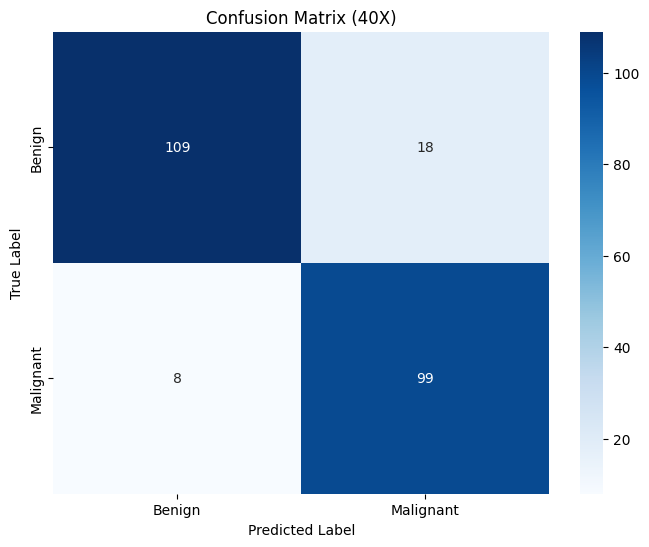

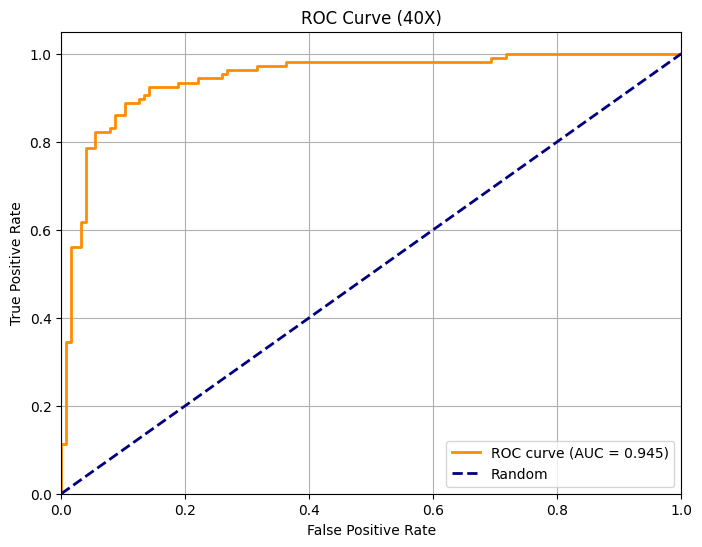

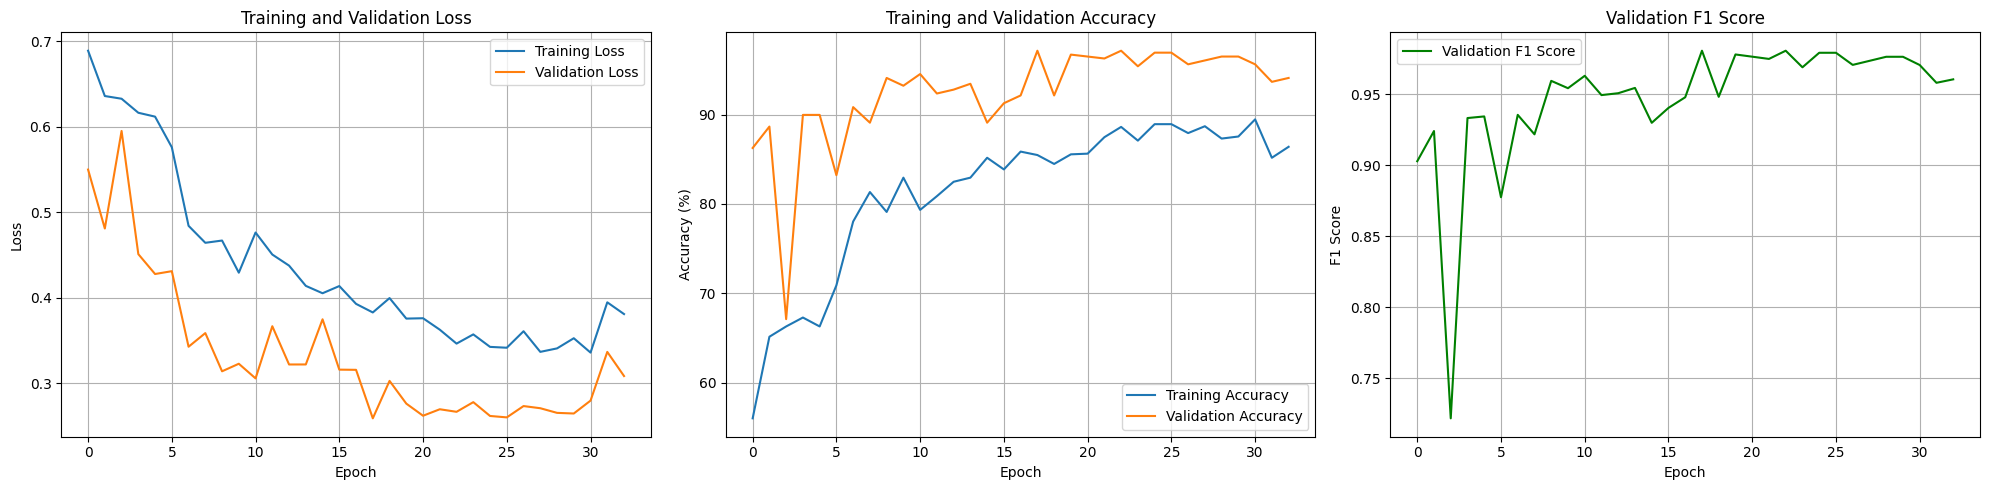


--- Training on 100X images ---
Patient-level split verified:
Train patients: 57
Val patients: 16
Test patients: 9


Epoch 1/50 [Val]: 100%|██████████| 14/14 [00:04<00:00,  3.32it/s, Loss=0.6113, Acc=78.57%]


Epoch 1/50:
Train Loss: 0.6578, Train Acc: 61.78%
Val Loss: 0.5438, Val Acc: 78.57%, Val F1: 0.8493
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.8493


Epoch 2/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s, Loss=0.4358, Acc=81.34%]


Epoch 2/50:
Train Loss: 0.6286, Train Acc: 64.22%
Val Loss: 0.4978, Val Acc: 81.34%, Val F1: 0.8760
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.8760


Epoch 3/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s, Loss=0.7961, Acc=63.13%]


Epoch 3/50:
Train Loss: 0.6380, Train Acc: 64.44%
Val Loss: 0.6571, Val Acc: 63.13%, Val F1: 0.6800
Current LR: 0.000009
--------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s, Loss=0.5023, Acc=81.57%]


Epoch 4/50:
Train Loss: 0.6246, Train Acc: 65.45%
Val Loss: 0.4768, Val Acc: 81.57%, Val F1: 0.8746
Current LR: 0.000008
--------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s, Loss=0.4963, Acc=82.72%]


Epoch 5/50:
Train Loss: 0.5993, Train Acc: 68.82%
Val Loss: 0.4655, Val Acc: 82.72%, Val F1: 0.8819
Current LR: 0.000007
--------------------------------------------------
New best model saved with F1: 0.8819


Epoch 6/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.36it/s, Loss=0.7878, Acc=82.72%]


Epoch 6/50:
Train Loss: 0.5685, Train Acc: 72.70%
Val Loss: 0.4707, Val Acc: 82.72%, Val F1: 0.8777
Current LR: 0.000005
--------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s, Loss=0.4794, Acc=85.71%]


Epoch 7/50:
Train Loss: 0.5238, Train Acc: 75.14%
Val Loss: 0.3940, Val Acc: 85.71%, Val F1: 0.9016
Current LR: 0.000004
--------------------------------------------------
New best model saved with F1: 0.9016


Epoch 8/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s, Loss=0.3042, Acc=87.10%]


Epoch 8/50:
Train Loss: 0.5174, Train Acc: 76.51%
Val Loss: 0.4168, Val Acc: 87.10%, Val F1: 0.9162
Current LR: 0.000003
--------------------------------------------------
New best model saved with F1: 0.9162


Epoch 9/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s, Loss=0.4482, Acc=86.41%]


Epoch 9/50:
Train Loss: 0.4856, Train Acc: 77.80%
Val Loss: 0.4205, Val Acc: 86.41%, Val F1: 0.9053
Current LR: 0.000002
--------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.30it/s, Loss=0.4200, Acc=85.94%]


Epoch 10/50:
Train Loss: 0.4656, Train Acc: 79.24%
Val Loss: 0.4216, Val Acc: 85.94%, Val F1: 0.9021
Current LR: 0.000001
--------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s, Loss=0.7601, Acc=88.94%]


Epoch 11/50:
Train Loss: 0.4843, Train Acc: 80.32%
Val Loss: 0.4217, Val Acc: 88.94%, Val F1: 0.9221
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9221


Epoch 12/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s, Loss=0.3942, Acc=89.40%]


Epoch 12/50:
Train Loss: 0.4860, Train Acc: 77.87%
Val Loss: 0.4204, Val Acc: 89.40%, Val F1: 0.9260
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9260


Epoch 13/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s, Loss=0.4537, Acc=92.63%]


Epoch 13/50:
Train Loss: 0.4682, Train Acc: 80.32%
Val Loss: 0.3691, Val Acc: 92.63%, Val F1: 0.9514
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9514


Epoch 14/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.35it/s, Loss=1.3052, Acc=82.26%]


Epoch 14/50:
Train Loss: 0.4327, Train Acc: 83.91%
Val Loss: 0.5519, Val Acc: 82.26%, Val F1: 0.8744
Current LR: 0.000010
--------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.34it/s, Loss=0.4159, Acc=91.47%]


Epoch 15/50:
Train Loss: 0.4197, Train Acc: 83.84%
Val Loss: 0.3439, Val Acc: 91.47%, Val F1: 0.9412
Current LR: 0.000009
--------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.38it/s, Loss=0.3779, Acc=91.01%]


Epoch 16/50:
Train Loss: 0.4210, Train Acc: 82.76%
Val Loss: 0.3603, Val Acc: 91.01%, Val F1: 0.9417
Current LR: 0.000009
--------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s, Loss=1.4242, Acc=88.25%]


Epoch 17/50:
Train Loss: 0.4043, Train Acc: 84.20%
Val Loss: 0.4426, Val Acc: 88.25%, Val F1: 0.9160
Current LR: 0.000008
--------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s, Loss=0.2118, Acc=87.79%]


Epoch 18/50:
Train Loss: 0.4011, Train Acc: 84.05%
Val Loss: 0.4015, Val Acc: 87.79%, Val F1: 0.9183
Current LR: 0.000008
--------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.32it/s, Loss=0.4079, Acc=92.17%]


Epoch 19/50:
Train Loss: 0.3971, Train Acc: 84.70%
Val Loss: 0.3463, Val Acc: 92.17%, Val F1: 0.9455
Current LR: 0.000007
--------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.35it/s, Loss=0.2221, Acc=92.40%]


Epoch 20/50:
Train Loss: 0.3898, Train Acc: 85.27%
Val Loss: 0.3186, Val Acc: 92.40%, Val F1: 0.9493
Current LR: 0.000006
--------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.37it/s, Loss=0.3158, Acc=92.40%]


Epoch 21/50:
Train Loss: 0.3967, Train Acc: 84.77%
Val Loss: 0.3228, Val Acc: 92.40%, Val F1: 0.9487
Current LR: 0.000005
--------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.35it/s, Loss=0.2446, Acc=92.86%]


Epoch 22/50:
Train Loss: 0.3867, Train Acc: 86.28%
Val Loss: 0.3320, Val Acc: 92.86%, Val F1: 0.9519
Current LR: 0.000005
--------------------------------------------------
New best model saved with F1: 0.9519


Epoch 23/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.38it/s, Loss=0.2912, Acc=93.55%]


Epoch 23/50:
Train Loss: 0.3713, Train Acc: 86.35%
Val Loss: 0.3118, Val Acc: 93.55%, Val F1: 0.9568
Current LR: 0.000004
--------------------------------------------------
New best model saved with F1: 0.9568


Epoch 24/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.40it/s, Loss=0.2678, Acc=91.47%]


Epoch 24/50:
Train Loss: 0.3527, Train Acc: 88.07%
Val Loss: 0.3398, Val Acc: 91.47%, Val F1: 0.9414
Current LR: 0.000003
--------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.40it/s, Loss=0.2861, Acc=94.47%]


Epoch 25/50:
Train Loss: 0.3556, Train Acc: 88.22%
Val Loss: 0.3114, Val Acc: 94.47%, Val F1: 0.9626
Current LR: 0.000003
--------------------------------------------------
New best model saved with F1: 0.9626


Epoch 26/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.36it/s, Loss=0.2934, Acc=94.01%]


Epoch 26/50:
Train Loss: 0.3540, Train Acc: 87.43%
Val Loss: 0.3003, Val Acc: 94.01%, Val F1: 0.9599
Current LR: 0.000002
--------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.40it/s, Loss=0.3166, Acc=93.78%]


Epoch 27/50:
Train Loss: 0.3601, Train Acc: 87.07%
Val Loss: 0.3066, Val Acc: 93.78%, Val F1: 0.9579
Current LR: 0.000002
--------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s, Loss=0.2695, Acc=93.32%]


Epoch 28/50:
Train Loss: 0.3566, Train Acc: 87.21%
Val Loss: 0.3159, Val Acc: 93.32%, Val F1: 0.9553
Current LR: 0.000001
--------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.34it/s, Loss=0.2516, Acc=93.32%]


Epoch 29/50:
Train Loss: 0.3495, Train Acc: 89.30%
Val Loss: 0.3237, Val Acc: 93.32%, Val F1: 0.9556
Current LR: 0.000001
--------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.35it/s, Loss=0.3083, Acc=93.55%]


Epoch 30/50:
Train Loss: 0.3493, Train Acc: 88.29%
Val Loss: 0.3198, Val Acc: 93.55%, Val F1: 0.9563
Current LR: 0.000001
--------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.34it/s, Loss=0.2218, Acc=88.25%]


Epoch 31/50:
Train Loss: 0.3851, Train Acc: 86.57%
Val Loss: 0.4299, Val Acc: 88.25%, Val F1: 0.9258
Current LR: 0.000010
--------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s, Loss=0.2546, Acc=91.71%]


Epoch 32/50:
Train Loss: 0.3853, Train Acc: 85.99%
Val Loss: 0.3435, Val Acc: 91.71%, Val F1: 0.9434
Current LR: 0.000010
--------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s, Loss=0.2113, Acc=88.25%]


Epoch 33/50:
Train Loss: 0.3977, Train Acc: 85.63%
Val Loss: 0.4053, Val Acc: 88.25%, Val F1: 0.9233
Current LR: 0.000010
--------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.32it/s, Loss=0.2655, Acc=88.02%]


Epoch 34/50:
Train Loss: 0.4058, Train Acc: 85.70%
Val Loss: 0.3844, Val Acc: 88.02%, Val F1: 0.9182
Current LR: 0.000010
--------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s, Loss=0.3148, Acc=89.63%]


Epoch 35/50:
Train Loss: 0.3877, Train Acc: 86.21%
Val Loss: 0.3832, Val Acc: 89.63%, Val F1: 0.9309
Current LR: 0.000010
--------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.22it/s, Loss=0.4425, Acc=88.02%]


Epoch 36/50:
Train Loss: 0.3772, Train Acc: 85.99%
Val Loss: 0.4092, Val Acc: 88.02%, Val F1: 0.9177
Current LR: 0.000010
--------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s, Loss=0.6920, Acc=91.24%]


Epoch 37/50:
Train Loss: 0.3705, Train Acc: 86.93%
Val Loss: 0.3663, Val Acc: 91.24%, Val F1: 0.9397
Current LR: 0.000010
--------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.03it/s, Loss=0.5951, Acc=89.63%]


Epoch 38/50:
Train Loss: 0.3658, Train Acc: 87.72%
Val Loss: 0.4002, Val Acc: 89.63%, Val F1: 0.9254
Current LR: 0.000009
--------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s, Loss=0.3084, Acc=91.01%]


Epoch 39/50:
Train Loss: 0.3690, Train Acc: 86.57%
Val Loss: 0.3419, Val Acc: 91.01%, Val F1: 0.9406
Current LR: 0.000009
--------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  3.88it/s, Loss=0.2426, Acc=92.86%]


Epoch 40/50:
Train Loss: 0.3516, Train Acc: 88.07%
Val Loss: 0.3340, Val Acc: 92.86%, Val F1: 0.9519
Current LR: 0.000009
--------------------------------------------------
Early stopping at epoch 40
Performing Test Time Augmentation...


TTA Evaluation: 100%|██████████| 255/255 [00:21<00:00, 11.93it/s]



Evaluation on 100X Magnification
Accuracy       : 0.8941
Precision      : 0.8852
Recall         : 0.8926
Specificity    : 0.8955
F1             : 0.8889
Auc_roc        : 0.9513

Confusion Matrix:
[[120  14]
 [ 13 108]]

True Positives (TP): 108, True Negatives (TN): 120
False Positives (FP): 14, False Negatives (FN): 13

Classification Report:
              precision    recall  f1-score   support

      Benign       0.90      0.90      0.90       134
   Malignant       0.89      0.89      0.89       121

    accuracy                           0.89       255
   macro avg       0.89      0.89      0.89       255
weighted avg       0.89      0.89      0.89       255




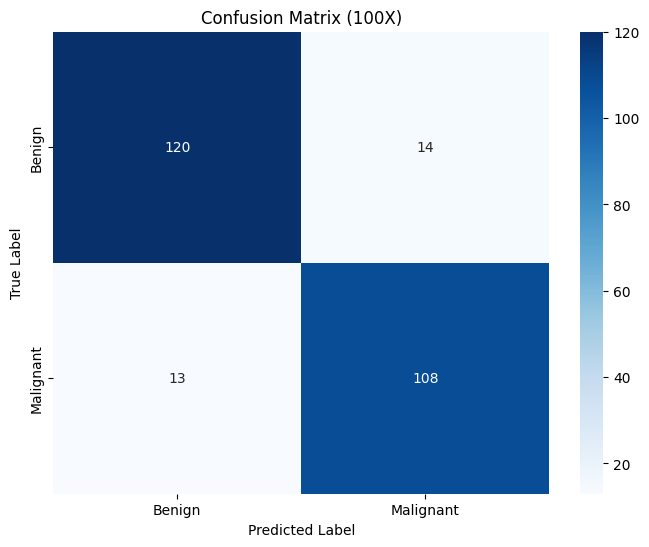

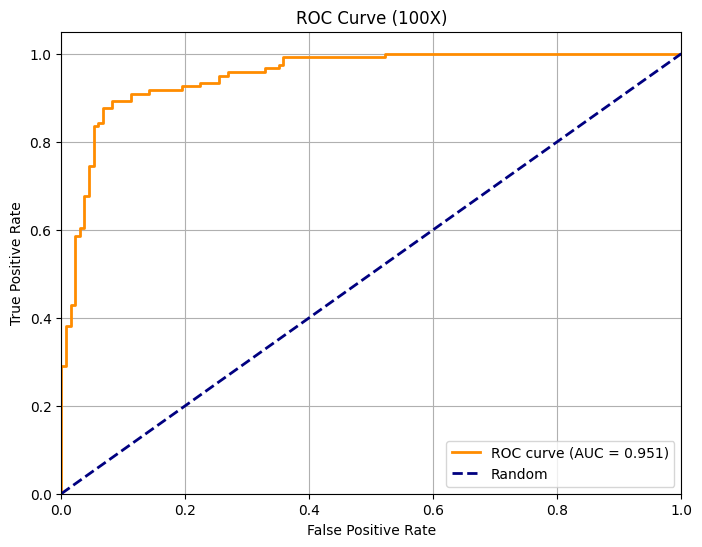

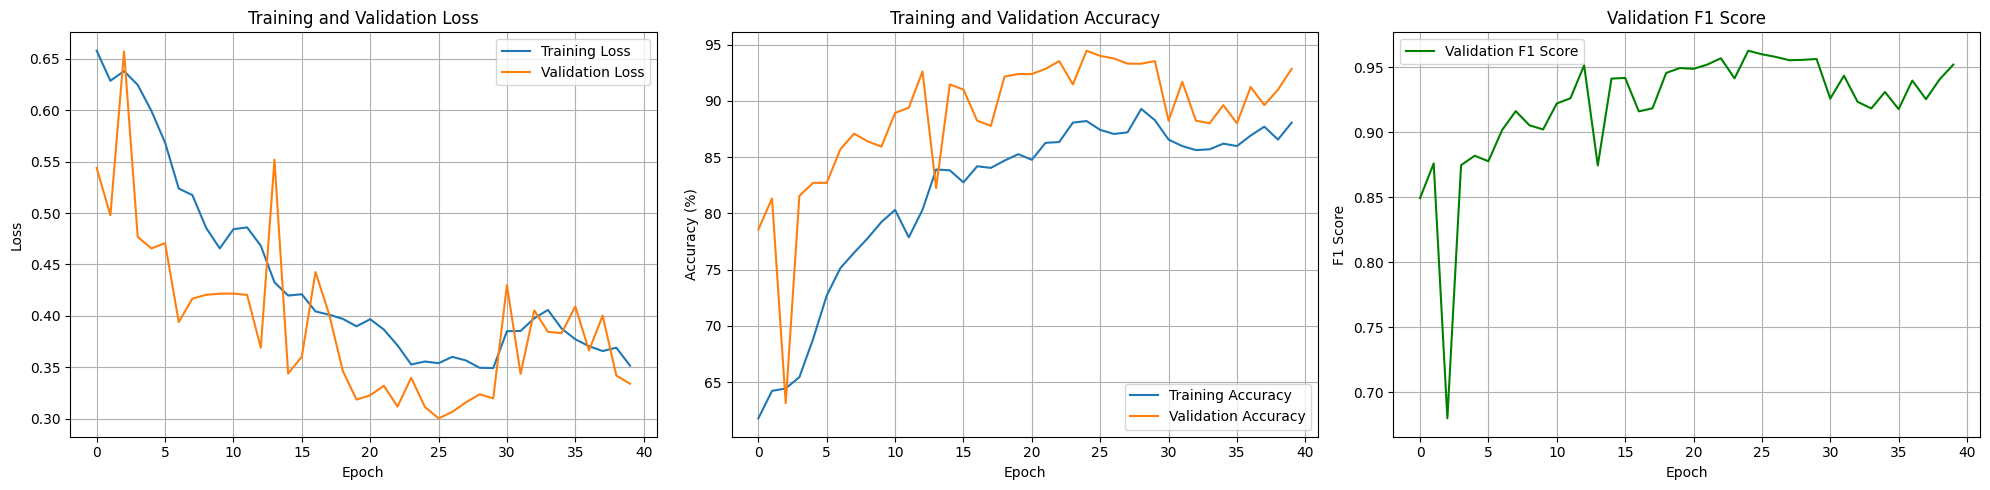


--- Training on 200X images ---
Patient-level split verified:
Train patients: 57
Val patients: 16
Test patients: 9


Epoch 1/50 [Val]: 100%|██████████| 14/14 [00:04<00:00,  2.97it/s, Loss=0.7730, Acc=78.57%]


Epoch 1/50:
Train Loss: 0.6793, Train Acc: 58.84%
Val Loss: 0.5581, Val Acc: 78.57%, Val F1: 0.8371
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.8371


Epoch 2/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.39it/s, Loss=0.6220, Acc=83.64%]


Epoch 2/50:
Train Loss: 0.6268, Train Acc: 66.35%
Val Loss: 0.4947, Val Acc: 83.64%, Val F1: 0.8834
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.8834


Epoch 3/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.40it/s, Loss=0.9275, Acc=64.98%]


Epoch 3/50:
Train Loss: 0.6143, Train Acc: 66.64%
Val Loss: 0.6090, Val Acc: 64.98%, Val F1: 0.6972
Current LR: 0.000009
--------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.44it/s, Loss=0.6362, Acc=82.26%]


Epoch 4/50:
Train Loss: 0.6032, Train Acc: 67.23%
Val Loss: 0.4875, Val Acc: 82.26%, Val F1: 0.8719
Current LR: 0.000008
--------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s, Loss=0.6101, Acc=83.41%]


Epoch 5/50:
Train Loss: 0.5950, Train Acc: 67.67%
Val Loss: 0.4810, Val Acc: 83.41%, Val F1: 0.8812
Current LR: 0.000007
--------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.40it/s, Loss=1.9790, Acc=68.89%]


Epoch 6/50:
Train Loss: 0.5739, Train Acc: 71.43%
Val Loss: 0.6988, Val Acc: 68.89%, Val F1: 0.7438
Current LR: 0.000005
--------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.40it/s, Loss=1.1148, Acc=82.72%]


Epoch 7/50:
Train Loss: 0.5401, Train Acc: 74.74%
Val Loss: 0.4626, Val Acc: 82.72%, Val F1: 0.8705
Current LR: 0.000004
--------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s, Loss=1.4669, Acc=88.71%]


Epoch 8/50:
Train Loss: 0.4907, Train Acc: 78.50%
Val Loss: 0.4273, Val Acc: 88.71%, Val F1: 0.9187
Current LR: 0.000003
--------------------------------------------------
New best model saved with F1: 0.9187


Epoch 9/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.31it/s, Loss=1.5557, Acc=89.17%]


Epoch 9/50:
Train Loss: 0.4538, Train Acc: 81.89%
Val Loss: 0.4288, Val Acc: 89.17%, Val F1: 0.9218
Current LR: 0.000002
--------------------------------------------------
New best model saved with F1: 0.9218


Epoch 10/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s, Loss=1.1956, Acc=89.86%]


Epoch 10/50:
Train Loss: 0.4938, Train Acc: 77.76%
Val Loss: 0.4036, Val Acc: 89.86%, Val F1: 0.9279
Current LR: 0.000001
--------------------------------------------------
New best model saved with F1: 0.9279


Epoch 11/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s, Loss=2.0093, Acc=91.71%]


Epoch 11/50:
Train Loss: 0.4982, Train Acc: 77.61%
Val Loss: 0.4293, Val Acc: 91.71%, Val F1: 0.9408
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9408


Epoch 12/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s, Loss=0.6245, Acc=89.40%]


Epoch 12/50:
Train Loss: 0.4799, Train Acc: 79.38%
Val Loss: 0.4156, Val Acc: 89.40%, Val F1: 0.9303
Current LR: 0.000010
--------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s, Loss=0.7126, Acc=90.55%]


Epoch 13/50:
Train Loss: 0.4759, Train Acc: 80.85%
Val Loss: 0.3820, Val Acc: 90.55%, Val F1: 0.9354
Current LR: 0.000010
--------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.44it/s, Loss=1.2808, Acc=88.25%]


Epoch 14/50:
Train Loss: 0.4542, Train Acc: 80.27%
Val Loss: 0.4298, Val Acc: 88.25%, Val F1: 0.9143
Current LR: 0.000010
--------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.33it/s, Loss=1.7582, Acc=90.55%]


Epoch 15/50:
Train Loss: 0.4207, Train Acc: 84.76%
Val Loss: 0.4326, Val Acc: 90.55%, Val F1: 0.9318
Current LR: 0.000009
--------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s, Loss=1.6332, Acc=87.79%]


Epoch 16/50:
Train Loss: 0.4210, Train Acc: 83.51%
Val Loss: 0.4741, Val Acc: 87.79%, Val F1: 0.9088
Current LR: 0.000009
--------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.45it/s, Loss=1.8883, Acc=91.71%]


Epoch 17/50:
Train Loss: 0.4229, Train Acc: 83.06%
Val Loss: 0.4149, Val Acc: 91.71%, Val F1: 0.9416
Current LR: 0.000008
--------------------------------------------------
New best model saved with F1: 0.9416


Epoch 18/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s, Loss=1.2365, Acc=92.63%]


Epoch 18/50:
Train Loss: 0.4018, Train Acc: 84.76%
Val Loss: 0.3509, Val Acc: 92.63%, Val F1: 0.9482
Current LR: 0.000008
--------------------------------------------------
New best model saved with F1: 0.9482


Epoch 19/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s, Loss=0.9321, Acc=89.63%]


Epoch 19/50:
Train Loss: 0.4150, Train Acc: 83.58%
Val Loss: 0.4063, Val Acc: 89.63%, Val F1: 0.9296
Current LR: 0.000007
--------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s, Loss=1.5286, Acc=88.71%]


Epoch 20/50:
Train Loss: 0.4095, Train Acc: 84.02%
Val Loss: 0.4749, Val Acc: 88.71%, Val F1: 0.9240
Current LR: 0.000006
--------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.30it/s, Loss=0.9989, Acc=90.32%]


Epoch 21/50:
Train Loss: 0.3949, Train Acc: 85.27%
Val Loss: 0.3805, Val Acc: 90.32%, Val F1: 0.9348
Current LR: 0.000005
--------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.39it/s, Loss=1.6589, Acc=90.55%]


Epoch 22/50:
Train Loss: 0.3802, Train Acc: 86.75%
Val Loss: 0.4206, Val Acc: 90.55%, Val F1: 0.9338
Current LR: 0.000005
--------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.11it/s, Loss=1.4036, Acc=93.32%]


Epoch 23/50:
Train Loss: 0.4028, Train Acc: 84.83%
Val Loss: 0.3565, Val Acc: 93.32%, Val F1: 0.9530
Current LR: 0.000004
--------------------------------------------------
New best model saved with F1: 0.9530


Epoch 24/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s, Loss=1.2415, Acc=90.32%]


Epoch 24/50:
Train Loss: 0.3847, Train Acc: 84.98%
Val Loss: 0.3805, Val Acc: 90.32%, Val F1: 0.9307
Current LR: 0.000003
--------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.26it/s, Loss=1.3971, Acc=91.47%]


Epoch 25/50:
Train Loss: 0.3586, Train Acc: 87.11%
Val Loss: 0.3837, Val Acc: 91.47%, Val F1: 0.9388
Current LR: 0.000003
--------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.39it/s, Loss=1.2130, Acc=91.47%]


Epoch 26/50:
Train Loss: 0.3819, Train Acc: 85.86%
Val Loss: 0.3739, Val Acc: 91.47%, Val F1: 0.9415
Current LR: 0.000002
--------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.36it/s, Loss=1.4994, Acc=91.47%]


Epoch 27/50:
Train Loss: 0.3532, Train Acc: 88.29%
Val Loss: 0.3832, Val Acc: 91.47%, Val F1: 0.9406
Current LR: 0.000002
--------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.37it/s, Loss=2.1953, Acc=91.01%]


Epoch 28/50:
Train Loss: 0.3528, Train Acc: 87.92%
Val Loss: 0.4399, Val Acc: 91.01%, Val F1: 0.9351
Current LR: 0.000001
--------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.35it/s, Loss=1.7075, Acc=93.32%]


Epoch 29/50:
Train Loss: 0.3722, Train Acc: 86.67%
Val Loss: 0.3813, Val Acc: 93.32%, Val F1: 0.9532
Current LR: 0.000001
--------------------------------------------------
New best model saved with F1: 0.9532


Epoch 30/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.32it/s, Loss=1.5766, Acc=92.63%]


Epoch 30/50:
Train Loss: 0.3755, Train Acc: 86.82%
Val Loss: 0.3754, Val Acc: 92.63%, Val F1: 0.9487
Current LR: 0.000001
--------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s, Loss=1.3486, Acc=82.95%]


Epoch 31/50:
Train Loss: 0.3790, Train Acc: 85.94%
Val Loss: 0.5140, Val Acc: 82.95%, Val F1: 0.8724
Current LR: 0.000010
--------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.36it/s, Loss=1.1466, Acc=90.32%]


Epoch 32/50:
Train Loss: 0.4070, Train Acc: 86.23%
Val Loss: 0.3849, Val Acc: 90.32%, Val F1: 0.9309
Current LR: 0.000010
--------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s, Loss=1.4916, Acc=90.55%]


Epoch 33/50:
Train Loss: 0.3985, Train Acc: 85.49%
Val Loss: 0.4064, Val Acc: 90.55%, Val F1: 0.9325
Current LR: 0.000010
--------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.37it/s, Loss=1.1208, Acc=93.32%]


Epoch 34/50:
Train Loss: 0.3905, Train Acc: 86.52%
Val Loss: 0.3599, Val Acc: 93.32%, Val F1: 0.9539
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9539


Epoch 35/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s, Loss=0.7525, Acc=91.24%]


Epoch 35/50:
Train Loss: 0.3814, Train Acc: 86.52%
Val Loss: 0.3685, Val Acc: 91.24%, Val F1: 0.9406
Current LR: 0.000010
--------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s, Loss=1.0518, Acc=89.86%]


Epoch 36/50:
Train Loss: 0.4045, Train Acc: 84.98%
Val Loss: 0.3908, Val Acc: 89.86%, Val F1: 0.9297
Current LR: 0.000010
--------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s, Loss=1.0922, Acc=90.09%]


Epoch 37/50:
Train Loss: 0.3781, Train Acc: 86.60%
Val Loss: 0.3978, Val Acc: 90.09%, Val F1: 0.9305
Current LR: 0.000010
--------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s, Loss=1.7274, Acc=90.55%]


Epoch 38/50:
Train Loss: 0.3745, Train Acc: 87.11%
Val Loss: 0.4113, Val Acc: 90.55%, Val F1: 0.9335
Current LR: 0.000009
--------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s, Loss=1.4045, Acc=92.63%]


Epoch 39/50:
Train Loss: 0.3611, Train Acc: 88.59%
Val Loss: 0.3676, Val Acc: 92.63%, Val F1: 0.9484
Current LR: 0.000009
--------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s, Loss=2.1746, Acc=90.09%]


Epoch 40/50:
Train Loss: 0.3588, Train Acc: 87.85%
Val Loss: 0.4396, Val Acc: 90.09%, Val F1: 0.9292
Current LR: 0.000009
--------------------------------------------------


Epoch 41/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s, Loss=1.0840, Acc=87.33%]


Epoch 41/50:
Train Loss: 0.3686, Train Acc: 87.26%
Val Loss: 0.4110, Val Acc: 87.33%, Val F1: 0.9106
Current LR: 0.000009
--------------------------------------------------


Epoch 42/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  3.96it/s, Loss=1.7839, Acc=85.94%]


Epoch 42/50:
Train Loss: 0.3618, Train Acc: 88.95%
Val Loss: 0.5019, Val Acc: 85.94%, Val F1: 0.8992
Current LR: 0.000008
--------------------------------------------------


Epoch 43/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s, Loss=1.1310, Acc=88.48%]


Epoch 43/50:
Train Loss: 0.3620, Train Acc: 87.48%
Val Loss: 0.4043, Val Acc: 88.48%, Val F1: 0.9214
Current LR: 0.000008
--------------------------------------------------


Epoch 44/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  3.75it/s, Loss=1.1751, Acc=89.63%]


Epoch 44/50:
Train Loss: 0.3553, Train Acc: 87.48%
Val Loss: 0.4057, Val Acc: 89.63%, Val F1: 0.9273
Current LR: 0.000008
--------------------------------------------------


Epoch 45/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s, Loss=1.0840, Acc=86.64%]


Epoch 45/50:
Train Loss: 0.3739, Train Acc: 86.38%
Val Loss: 0.4098, Val Acc: 86.64%, Val F1: 0.9082
Current LR: 0.000008
--------------------------------------------------


Epoch 46/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  3.91it/s, Loss=1.3337, Acc=88.71%]


Epoch 46/50:
Train Loss: 0.3602, Train Acc: 87.85%
Val Loss: 0.4289, Val Acc: 88.71%, Val F1: 0.9221
Current LR: 0.000007
--------------------------------------------------


Epoch 47/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.38it/s, Loss=0.6431, Acc=87.33%]


Epoch 47/50:
Train Loss: 0.3530, Train Acc: 87.70%
Val Loss: 0.3917, Val Acc: 87.33%, Val F1: 0.9158
Current LR: 0.000007
--------------------------------------------------


Epoch 48/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.21it/s, Loss=0.7451, Acc=91.24%]


Epoch 48/50:
Train Loss: 0.3588, Train Acc: 88.44%
Val Loss: 0.3637, Val Acc: 91.24%, Val F1: 0.9410
Current LR: 0.000007
--------------------------------------------------


Epoch 49/50 [Val]: 100%|██████████| 14/14 [00:03<00:00,  4.33it/s, Loss=1.4189, Acc=88.71%]


Epoch 49/50:
Train Loss: 0.3426, Train Acc: 88.29%
Val Loss: 0.4110, Val Acc: 88.71%, Val F1: 0.9221
Current LR: 0.000006
--------------------------------------------------
Early stopping at epoch 49
Performing Test Time Augmentation...


TTA Evaluation: 100%|██████████| 221/221 [00:19<00:00, 11.12it/s]



Evaluation on 200X Magnification
Accuracy       : 0.8643
Precision      : 0.7928
Recall         : 0.9263
Specificity    : 0.8175
F1             : 0.8544
Auc_roc        : 0.9618

Confusion Matrix:
[[103  23]
 [  7  88]]

True Positives (TP): 88, True Negatives (TN): 103
False Positives (FP): 23, False Negatives (FN): 7

Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      0.82      0.87       126
   Malignant       0.79      0.93      0.85        95

    accuracy                           0.86       221
   macro avg       0.86      0.87      0.86       221
weighted avg       0.87      0.86      0.86       221




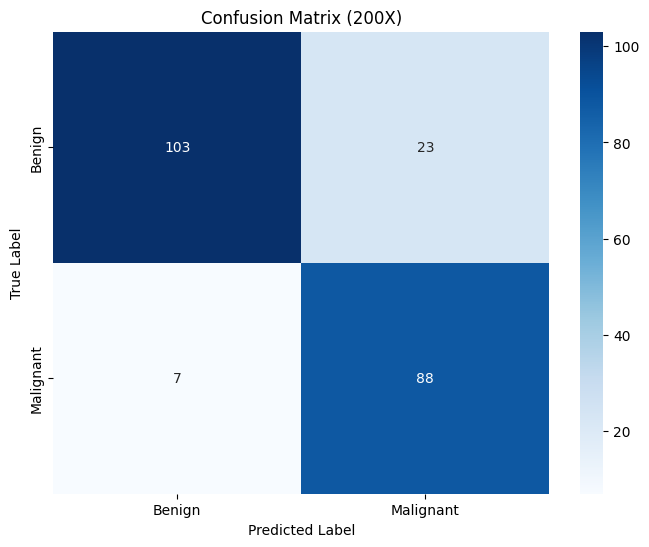

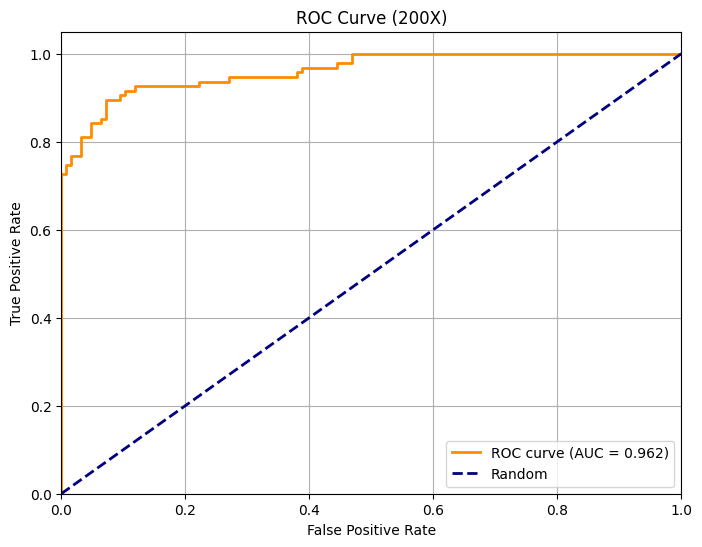

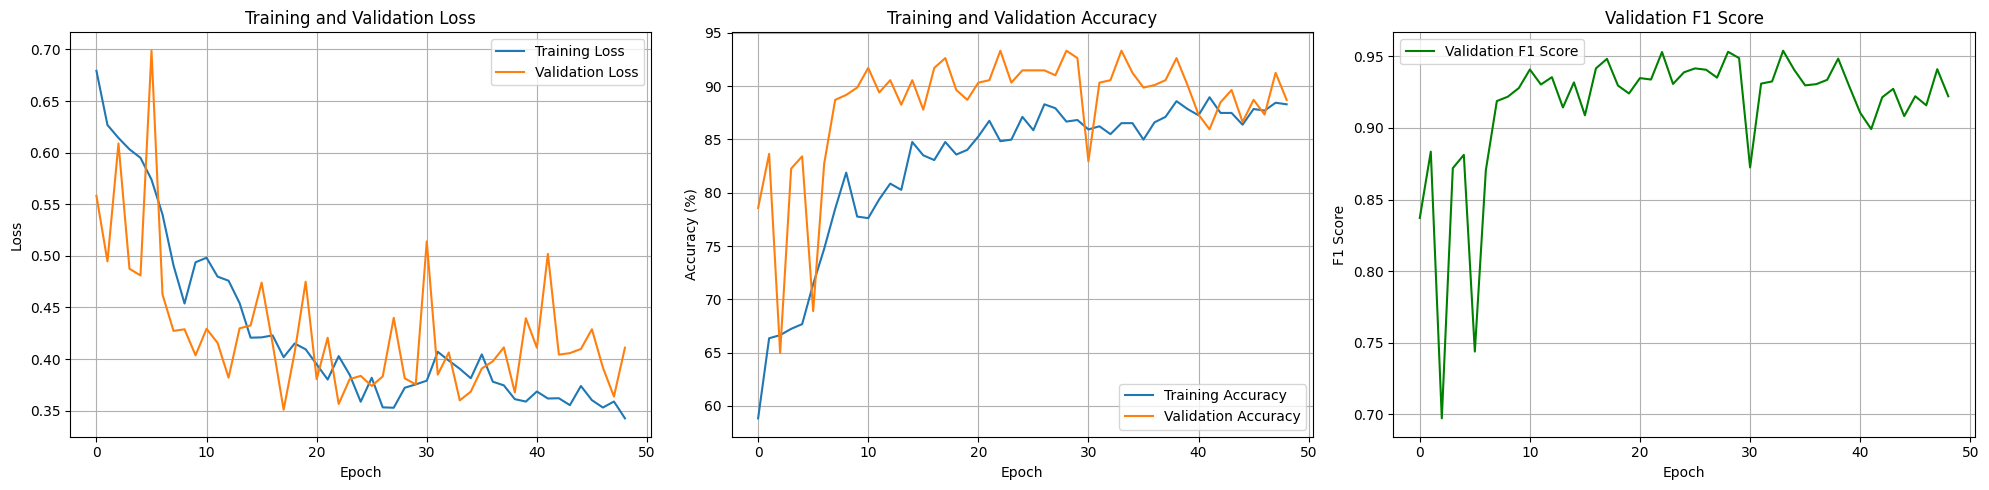


--- Training on 400X images ---
Patient-level split verified:
Train patients: 57
Val patients: 16
Test patients: 9


Epoch 1/50 [Val]: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s, Loss=1.0552, Acc=49.74%]


Epoch 1/50:
Train Loss: 0.6829, Train Acc: 57.52%
Val Loss: 0.7313, Val Acc: 49.74%, Val F1: 0.4628
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.4628


Epoch 2/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.77it/s, Loss=0.7201, Acc=77.84%]


Epoch 2/50:
Train Loss: 0.6513, Train Acc: 63.01%
Val Loss: 0.5605, Val Acc: 77.84%, Val F1: 0.8340
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.8340


Epoch 3/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.87it/s, Loss=0.7362, Acc=68.30%]


Epoch 3/50:
Train Loss: 0.6637, Train Acc: 60.68%
Val Loss: 0.6022, Val Acc: 68.30%, Val F1: 0.7389
Current LR: 0.000009
--------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.80it/s, Loss=0.6567, Acc=77.84%]


Epoch 4/50:
Train Loss: 0.6286, Train Acc: 63.67%
Val Loss: 0.5484, Val Acc: 77.84%, Val F1: 0.8365
Current LR: 0.000008
--------------------------------------------------
New best model saved with F1: 0.8365


Epoch 5/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.84it/s, Loss=0.6855, Acc=75.52%]


Epoch 5/50:
Train Loss: 0.6068, Train Acc: 67.41%
Val Loss: 0.5544, Val Acc: 75.52%, Val F1: 0.8155
Current LR: 0.000007
--------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.82it/s, Loss=0.8991, Acc=73.20%]


Epoch 6/50:
Train Loss: 0.5815, Train Acc: 72.65%
Val Loss: 0.5780, Val Acc: 73.20%, Val F1: 0.7759
Current LR: 0.000005
--------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s, Loss=0.7004, Acc=78.35%]


Epoch 7/50:
Train Loss: 0.5496, Train Acc: 73.15%
Val Loss: 0.5307, Val Acc: 78.35%, Val F1: 0.8359
Current LR: 0.000004
--------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s, Loss=0.8464, Acc=75.52%]


Epoch 8/50:
Train Loss: 0.5229, Train Acc: 75.23%
Val Loss: 0.5966, Val Acc: 75.52%, Val F1: 0.8033
Current LR: 0.000003
--------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s, Loss=0.5229, Acc=82.47%]


Epoch 9/50:
Train Loss: 0.5017, Train Acc: 77.81%
Val Loss: 0.4734, Val Acc: 82.47%, Val F1: 0.8687
Current LR: 0.000002
--------------------------------------------------
New best model saved with F1: 0.8687


Epoch 10/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s, Loss=0.4667, Acc=83.51%]


Epoch 10/50:
Train Loss: 0.5000, Train Acc: 76.56%
Val Loss: 0.4744, Val Acc: 83.51%, Val F1: 0.8764
Current LR: 0.000001
--------------------------------------------------
New best model saved with F1: 0.8764


Epoch 11/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.80it/s, Loss=0.3003, Acc=84.02%]


Epoch 11/50:
Train Loss: 0.5264, Train Acc: 77.14%
Val Loss: 0.4933, Val Acc: 84.02%, Val F1: 0.8905
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.8905


Epoch 12/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.84it/s, Loss=0.2366, Acc=90.98%]


Epoch 12/50:
Train Loss: 0.5286, Train Acc: 76.56%
Val Loss: 0.3496, Val Acc: 90.98%, Val F1: 0.9362
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.9362


Epoch 13/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s, Loss=0.3798, Acc=88.40%]


Epoch 13/50:
Train Loss: 0.4762, Train Acc: 79.63%
Val Loss: 0.3847, Val Acc: 88.40%, Val F1: 0.9162
Current LR: 0.000010
--------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.58it/s, Loss=0.3444, Acc=86.60%]


Epoch 14/50:
Train Loss: 0.4805, Train Acc: 79.30%
Val Loss: 0.4158, Val Acc: 86.60%, Val F1: 0.9030
Current LR: 0.000010
--------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s, Loss=0.3093, Acc=89.43%]


Epoch 15/50:
Train Loss: 0.4832, Train Acc: 77.64%
Val Loss: 0.3913, Val Acc: 89.43%, Val F1: 0.9201
Current LR: 0.000009
--------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.84it/s, Loss=0.2237, Acc=90.46%]


Epoch 16/50:
Train Loss: 0.4481, Train Acc: 83.04%
Val Loss: 0.3463, Val Acc: 90.46%, Val F1: 0.9311
Current LR: 0.000009
--------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.88it/s, Loss=0.4496, Acc=87.89%]


Epoch 17/50:
Train Loss: 0.4503, Train Acc: 81.21%
Val Loss: 0.4350, Val Acc: 87.89%, Val F1: 0.9077
Current LR: 0.000008
--------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s, Loss=0.2196, Acc=88.40%]


Epoch 18/50:
Train Loss: 0.4165, Train Acc: 84.29%
Val Loss: 0.3626, Val Acc: 88.40%, Val F1: 0.9195
Current LR: 0.000008
--------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.68it/s, Loss=0.2133, Acc=87.11%]


Epoch 19/50:
Train Loss: 0.4212, Train Acc: 83.79%
Val Loss: 0.3999, Val Acc: 87.11%, Val F1: 0.9132
Current LR: 0.000007
--------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s, Loss=0.2015, Acc=87.11%]


Epoch 20/50:
Train Loss: 0.4111, Train Acc: 84.79%
Val Loss: 0.3946, Val Acc: 87.11%, Val F1: 0.9104
Current LR: 0.000006
--------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s, Loss=0.2385, Acc=91.49%]


Epoch 21/50:
Train Loss: 0.4265, Train Acc: 83.46%
Val Loss: 0.3298, Val Acc: 91.49%, Val F1: 0.9390
Current LR: 0.000005
--------------------------------------------------
New best model saved with F1: 0.9390


Epoch 22/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.79it/s, Loss=0.2026, Acc=89.95%]


Epoch 22/50:
Train Loss: 0.4239, Train Acc: 83.46%
Val Loss: 0.3659, Val Acc: 89.95%, Val F1: 0.9276
Current LR: 0.000005
--------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.85it/s, Loss=0.2026, Acc=91.49%]


Epoch 23/50:
Train Loss: 0.3973, Train Acc: 83.71%
Val Loss: 0.3361, Val Acc: 91.49%, Val F1: 0.9383
Current LR: 0.000004
--------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.87it/s, Loss=0.2023, Acc=91.24%]


Epoch 24/50:
Train Loss: 0.3832, Train Acc: 85.54%
Val Loss: 0.3315, Val Acc: 91.24%, Val F1: 0.9388
Current LR: 0.000003
--------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.75it/s, Loss=0.2011, Acc=92.53%]


Epoch 25/50:
Train Loss: 0.3768, Train Acc: 86.95%
Val Loss: 0.3152, Val Acc: 92.53%, Val F1: 0.9479
Current LR: 0.000003
--------------------------------------------------
New best model saved with F1: 0.9479


Epoch 26/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.85it/s, Loss=0.2012, Acc=92.53%]


Epoch 26/50:
Train Loss: 0.3817, Train Acc: 85.54%
Val Loss: 0.3180, Val Acc: 92.53%, Val F1: 0.9476
Current LR: 0.000002
--------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.79it/s, Loss=0.2037, Acc=93.30%]


Epoch 27/50:
Train Loss: 0.3949, Train Acc: 84.87%
Val Loss: 0.3091, Val Acc: 93.30%, Val F1: 0.9527
Current LR: 0.000002
--------------------------------------------------
New best model saved with F1: 0.9527


Epoch 28/50 [Val]: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s, Loss=0.2104, Acc=92.78%]


Epoch 28/50:
Train Loss: 0.3900, Train Acc: 85.04%
Val Loss: 0.3202, Val Acc: 92.78%, Val F1: 0.9481
Current LR: 0.000001
--------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.71it/s, Loss=0.2136, Acc=93.04%]


Epoch 29/50:
Train Loss: 0.3901, Train Acc: 84.70%
Val Loss: 0.3124, Val Acc: 93.04%, Val F1: 0.9503
Current LR: 0.000001
--------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.85it/s, Loss=0.2050, Acc=92.01%]


Epoch 30/50:
Train Loss: 0.3678, Train Acc: 87.12%
Val Loss: 0.3171, Val Acc: 92.01%, Val F1: 0.9437
Current LR: 0.000001
--------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.84it/s, Loss=0.2937, Acc=90.72%]


Epoch 31/50:
Train Loss: 0.3873, Train Acc: 85.79%
Val Loss: 0.3578, Val Acc: 90.72%, Val F1: 0.9321
Current LR: 0.000010
--------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s, Loss=0.2636, Acc=90.46%]


Epoch 32/50:
Train Loss: 0.4252, Train Acc: 82.21%
Val Loss: 0.3622, Val Acc: 90.46%, Val F1: 0.9326
Current LR: 0.000010
--------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s, Loss=0.2841, Acc=88.40%]


Epoch 33/50:
Train Loss: 0.4219, Train Acc: 84.62%
Val Loss: 0.4138, Val Acc: 88.40%, Val F1: 0.9153
Current LR: 0.000010
--------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s, Loss=0.2060, Acc=90.72%]


Epoch 34/50:
Train Loss: 0.4153, Train Acc: 84.04%
Val Loss: 0.3610, Val Acc: 90.72%, Val F1: 0.9366
Current LR: 0.000010
--------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.49it/s, Loss=0.3672, Acc=86.60%]


Epoch 35/50:
Train Loss: 0.4216, Train Acc: 82.96%
Val Loss: 0.4131, Val Acc: 86.60%, Val F1: 0.8976
Current LR: 0.000010
--------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.84it/s, Loss=0.2362, Acc=88.40%]


Epoch 36/50:
Train Loss: 0.4157, Train Acc: 82.88%
Val Loss: 0.3531, Val Acc: 88.40%, Val F1: 0.9204
Current LR: 0.000010
--------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s, Loss=0.2011, Acc=88.66%]


Epoch 37/50:
Train Loss: 0.3919, Train Acc: 86.03%
Val Loss: 0.3796, Val Acc: 88.66%, Val F1: 0.9214
Current LR: 0.000010
--------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.72it/s, Loss=0.2511, Acc=85.05%]


Epoch 38/50:
Train Loss: 0.4037, Train Acc: 85.20%
Val Loss: 0.4532, Val Acc: 85.05%, Val F1: 0.9024
Current LR: 0.000009
--------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.82it/s, Loss=0.2045, Acc=88.14%]


Epoch 39/50:
Train Loss: 0.3945, Train Acc: 86.12%
Val Loss: 0.3840, Val Acc: 88.14%, Val F1: 0.9204
Current LR: 0.000009
--------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.74it/s, Loss=0.2126, Acc=89.95%]


Epoch 40/50:
Train Loss: 0.4010, Train Acc: 85.29%
Val Loss: 0.3551, Val Acc: 89.95%, Val F1: 0.9317
Current LR: 0.000009
--------------------------------------------------


Epoch 41/50 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.74it/s, Loss=0.2059, Acc=88.66%]


Epoch 41/50:
Train Loss: 0.3828, Train Acc: 86.78%
Val Loss: 0.4072, Val Acc: 88.66%, Val F1: 0.9223
Current LR: 0.000009
--------------------------------------------------


Epoch 42/50 [Val]: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s, Loss=0.2001, Acc=89.18%]


Epoch 42/50:
Train Loss: 0.3700, Train Acc: 87.61%
Val Loss: 0.3695, Val Acc: 89.18%, Val F1: 0.9266
Current LR: 0.000008
--------------------------------------------------
Early stopping at epoch 42
Performing Test Time Augmentation...


TTA Evaluation: 100%|██████████| 229/229 [00:19<00:00, 12.05it/s]



Evaluation on 400X Magnification
Accuracy       : 0.8428
Precision      : 0.7925
Recall         : 0.8571
Specificity    : 0.8321
F1             : 0.8235
Auc_roc        : 0.9156

Confusion Matrix:
[[109  22]
 [ 14  84]]

True Positives (TP): 84, True Negatives (TN): 109
False Positives (FP): 22, False Negatives (FN): 14

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.83      0.86       131
   Malignant       0.79      0.86      0.82        98

    accuracy                           0.84       229
   macro avg       0.84      0.84      0.84       229
weighted avg       0.85      0.84      0.84       229




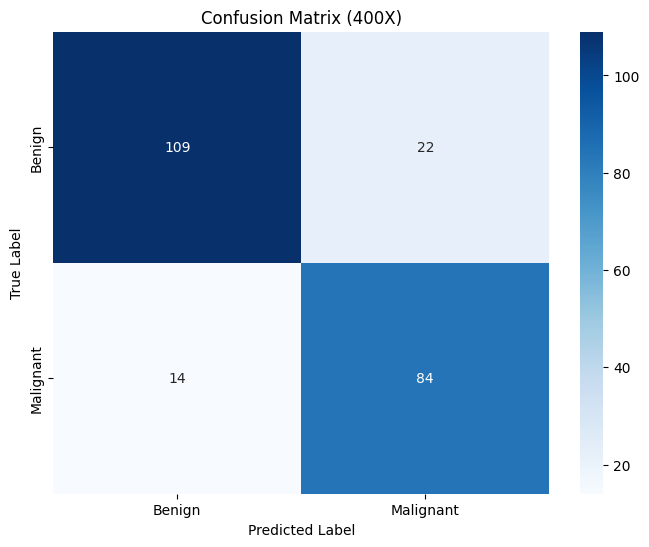

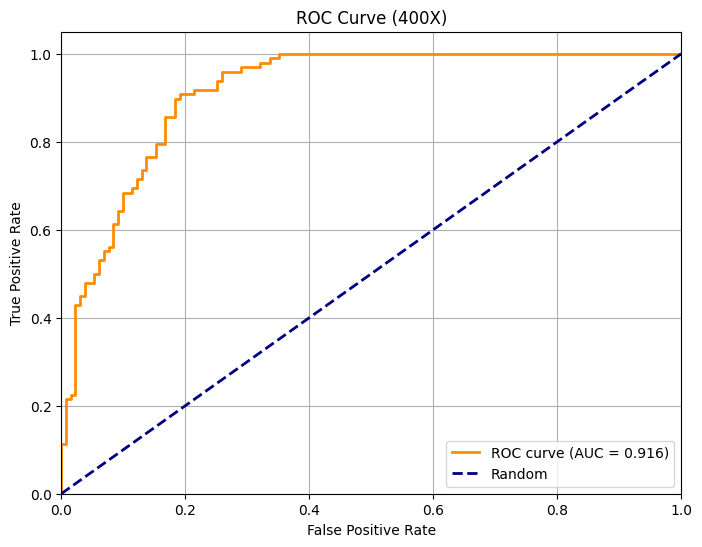

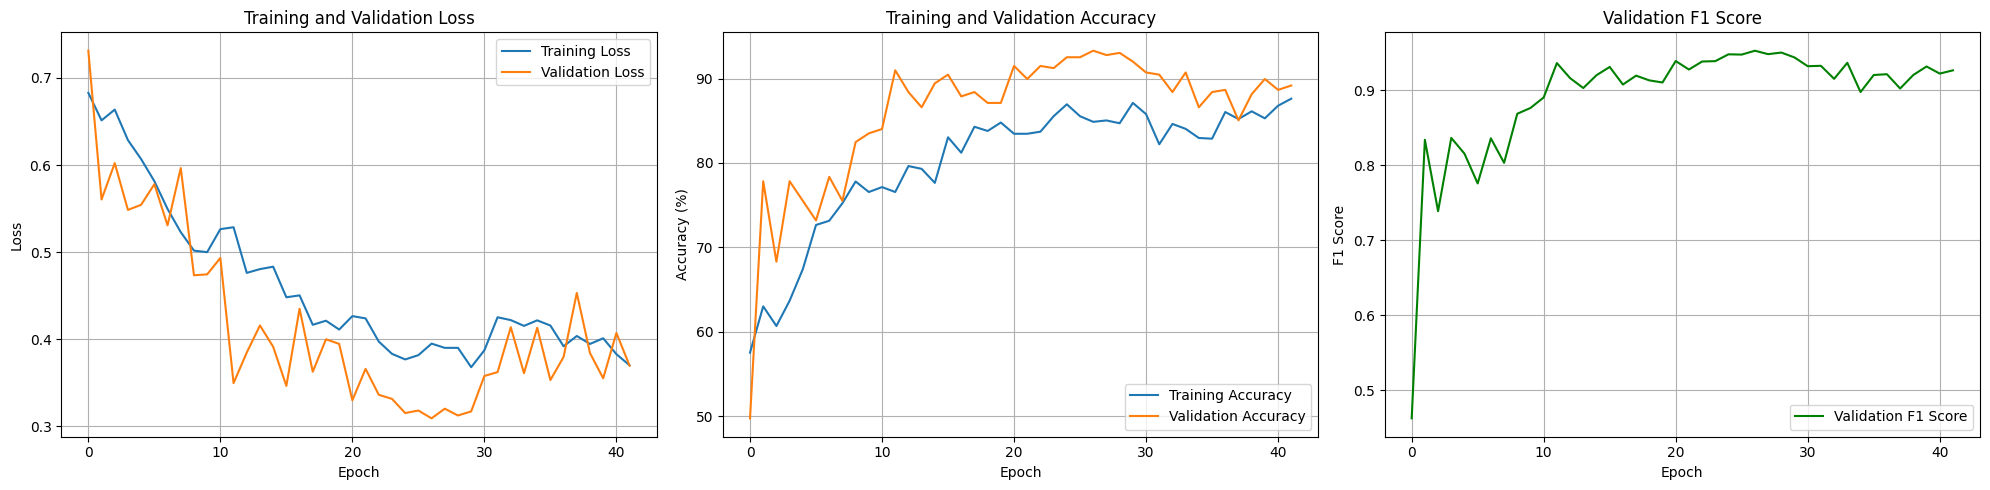


--- Training on ALL magnifications ---
Patient-level split verified:
Train patients: 57
Val patients: 16
Test patients: 9


Epoch 1/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.74it/s, Loss=0.6180, Acc=76.97%]


Epoch 1/50:
Train Loss: 0.6589, Train Acc: 61.83%
Val Loss: 0.5497, Val Acc: 76.97%, Val F1: 0.8360
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.8360


Epoch 2/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.67it/s, Loss=0.4088, Acc=82.62%]


Epoch 2/50:
Train Loss: 0.6312, Train Acc: 64.91%
Val Loss: 0.4948, Val Acc: 82.62%, Val F1: 0.8895
Current LR: 0.000010
--------------------------------------------------
New best model saved with F1: 0.8895


Epoch 3/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.83it/s, Loss=0.5183, Acc=83.32%]


Epoch 3/50:
Train Loss: 0.6204, Train Acc: 66.51%
Val Loss: 0.4832, Val Acc: 83.32%, Val F1: 0.8887
Current LR: 0.000009
--------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.85it/s, Loss=0.5601, Acc=82.10%]


Epoch 4/50:
Train Loss: 0.6134, Train Acc: 67.31%
Val Loss: 0.4933, Val Acc: 82.10%, Val F1: 0.8788
Current LR: 0.000008
--------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.70it/s, Loss=0.8665, Acc=75.04%]


Epoch 5/50:
Train Loss: 0.6025, Train Acc: 68.33%
Val Loss: 0.5458, Val Acc: 75.04%, Val F1: 0.8116
Current LR: 0.000007
--------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.78it/s, Loss=1.3432, Acc=81.40%]


Epoch 6/50:
Train Loss: 0.5669, Train Acc: 71.97%
Val Loss: 0.5131, Val Acc: 81.40%, Val F1: 0.8617
Current LR: 0.000005
--------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 54/54 [00:10<00:00,  4.91it/s, Loss=0.4396, Acc=85.36%]


Epoch 7/50:
Train Loss: 0.5144, Train Acc: 75.93%
Val Loss: 0.4680, Val Acc: 85.36%, Val F1: 0.9009
Current LR: 0.000004
--------------------------------------------------
New best model saved with F1: 0.9009


Epoch 8/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.78it/s, Loss=0.5433, Acc=86.76%]


Epoch 8/50:
Train Loss: 0.4762, Train Acc: 79.14%
Val Loss: 0.4170, Val Acc: 86.76%, Val F1: 0.9082
Current LR: 0.000003
--------------------------------------------------
New best model saved with F1: 0.9082


Epoch 9/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.90it/s, Loss=0.8567, Acc=88.28%]


Epoch 9/50:
Train Loss: 0.4580, Train Acc: 80.69%
Val Loss: 0.3963, Val Acc: 88.28%, Val F1: 0.9174
Current LR: 0.000002
--------------------------------------------------
New best model saved with F1: 0.9174


Epoch 10/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.85it/s, Loss=0.5990, Acc=89.74%]


Epoch 10/50:
Train Loss: 0.4461, Train Acc: 81.54%
Val Loss: 0.3906, Val Acc: 89.74%, Val F1: 0.9294
Current LR: 0.000001
--------------------------------------------------
New best model saved with F1: 0.9294


Epoch 11/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.89it/s, Loss=0.8719, Acc=81.52%]


Epoch 11/50:
Train Loss: 0.5019, Train Acc: 77.45%
Val Loss: 0.5225, Val Acc: 81.52%, Val F1: 0.8648
Current LR: 0.000010
--------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.76it/s, Loss=0.5673, Acc=88.63%]


Epoch 12/50:
Train Loss: 0.4812, Train Acc: 78.92%
Val Loss: 0.3962, Val Acc: 88.63%, Val F1: 0.9209
Current LR: 0.000010
--------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, Loss=0.5154, Acc=88.57%]


Epoch 13/50:
Train Loss: 0.4681, Train Acc: 80.57%
Val Loss: 0.4371, Val Acc: 88.57%, Val F1: 0.9230
Current LR: 0.000010
--------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.79it/s, Loss=0.6750, Acc=88.05%]


Epoch 14/50:
Train Loss: 0.4492, Train Acc: 81.20%
Val Loss: 0.3955, Val Acc: 88.05%, Val F1: 0.9153
Current LR: 0.000010
--------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.80it/s, Loss=0.9399, Acc=88.45%]


Epoch 15/50:
Train Loss: 0.4388, Train Acc: 82.87%
Val Loss: 0.3951, Val Acc: 88.45%, Val F1: 0.9161
Current LR: 0.000009
--------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 54/54 [00:10<00:00,  4.92it/s, Loss=0.8446, Acc=87.17%]


Epoch 16/50:
Train Loss: 0.4341, Train Acc: 83.04%
Val Loss: 0.4284, Val Acc: 87.17%, Val F1: 0.9095
Current LR: 0.000009
--------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 54/54 [00:10<00:00,  4.91it/s, Loss=1.0279, Acc=91.49%]


Epoch 17/50:
Train Loss: 0.4283, Train Acc: 82.06%
Val Loss: 0.3626, Val Acc: 91.49%, Val F1: 0.9399
Current LR: 0.000008
--------------------------------------------------
New best model saved with F1: 0.9399


Epoch 18/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.50it/s, Loss=0.7288, Acc=90.26%]


Epoch 18/50:
Train Loss: 0.4074, Train Acc: 83.90%
Val Loss: 0.3687, Val Acc: 90.26%, Val F1: 0.9316
Current LR: 0.000008
--------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.52it/s, Loss=0.4614, Acc=93.12%]


Epoch 19/50:
Train Loss: 0.3990, Train Acc: 84.68%
Val Loss: 0.3215, Val Acc: 93.12%, Val F1: 0.9524
Current LR: 0.000007
--------------------------------------------------
New best model saved with F1: 0.9524


Epoch 20/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.80it/s, Loss=0.8138, Acc=91.08%]


Epoch 20/50:
Train Loss: 0.3979, Train Acc: 84.81%
Val Loss: 0.3631, Val Acc: 91.08%, Val F1: 0.9391
Current LR: 0.000006
--------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 54/54 [00:10<00:00,  4.92it/s, Loss=1.8640, Acc=87.52%]


Epoch 21/50:
Train Loss: 0.3867, Train Acc: 85.84%
Val Loss: 0.4509, Val Acc: 87.52%, Val F1: 0.9102
Current LR: 0.000005
--------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 54/54 [00:10<00:00,  4.93it/s, Loss=0.9451, Acc=90.03%]


Epoch 22/50:
Train Loss: 0.3867, Train Acc: 86.03%
Val Loss: 0.3719, Val Acc: 90.03%, Val F1: 0.9299
Current LR: 0.000005
--------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.70it/s, Loss=0.4752, Acc=91.02%]


Epoch 23/50:
Train Loss: 0.3779, Train Acc: 86.57%
Val Loss: 0.3793, Val Acc: 91.02%, Val F1: 0.9400
Current LR: 0.000004
--------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.78it/s, Loss=0.4873, Acc=92.48%]


Epoch 24/50:
Train Loss: 0.3748, Train Acc: 86.07%
Val Loss: 0.3287, Val Acc: 92.48%, Val F1: 0.9486
Current LR: 0.000003
--------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.83it/s, Loss=0.6572, Acc=93.00%]


Epoch 25/50:
Train Loss: 0.3625, Train Acc: 87.12%
Val Loss: 0.3265, Val Acc: 93.00%, Val F1: 0.9513
Current LR: 0.000003
--------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.83it/s, Loss=0.6190, Acc=92.77%]


Epoch 26/50:
Train Loss: 0.3559, Train Acc: 87.48%
Val Loss: 0.3208, Val Acc: 92.77%, Val F1: 0.9509
Current LR: 0.000002
--------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.89it/s, Loss=0.5712, Acc=92.01%]


Epoch 27/50:
Train Loss: 0.3547, Train Acc: 87.76%
Val Loss: 0.3361, Val Acc: 92.01%, Val F1: 0.9451
Current LR: 0.000002
--------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s, Loss=0.3307, Acc=91.43%]


Epoch 28/50:
Train Loss: 0.3664, Train Acc: 86.51%
Val Loss: 0.3330, Val Acc: 91.43%, Val F1: 0.9424
Current LR: 0.000001
--------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, Loss=0.4314, Acc=92.71%]


Epoch 29/50:
Train Loss: 0.3546, Train Acc: 88.79%
Val Loss: 0.3206, Val Acc: 92.71%, Val F1: 0.9507
Current LR: 0.000001
--------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.81it/s, Loss=0.4112, Acc=91.72%]


Epoch 30/50:
Train Loss: 0.3537, Train Acc: 88.11%
Val Loss: 0.3356, Val Acc: 91.72%, Val F1: 0.9443
Current LR: 0.000001
--------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.80it/s, Loss=1.3448, Acc=86.36%]


Epoch 31/50:
Train Loss: 0.4092, Train Acc: 84.24%
Val Loss: 0.4491, Val Acc: 86.36%, Val F1: 0.9052
Current LR: 0.000010
--------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, Loss=1.0158, Acc=91.49%]


Epoch 32/50:
Train Loss: 0.4135, Train Acc: 84.34%
Val Loss: 0.3640, Val Acc: 91.49%, Val F1: 0.9405
Current LR: 0.000010
--------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.70it/s, Loss=1.1592, Acc=89.68%]


Epoch 33/50:
Train Loss: 0.3988, Train Acc: 84.95%
Val Loss: 0.3966, Val Acc: 89.68%, Val F1: 0.9270
Current LR: 0.000010
--------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 54/54 [00:11<00:00,  4.61it/s, Loss=0.7050, Acc=92.71%]


Epoch 34/50:
Train Loss: 0.4078, Train Acc: 83.88%
Val Loss: 0.3313, Val Acc: 92.71%, Val F1: 0.9502
Current LR: 0.000010
--------------------------------------------------
Early stopping at epoch 34
Performing Test Time Augmentation...


TTA Evaluation: 100%|██████████| 939/939 [01:05<00:00, 14.44it/s]



Evaluation on All Magnification
Accuracy       : 0.8647
Precision      : 0.8973
Recall         : 0.7886
Specificity    : 0.9266
F1             : 0.8394
Auc_roc        : 0.9379

Confusion Matrix:
[[480  38]
 [ 89 332]]

True Positives (TP): 332, True Negatives (TN): 480
False Positives (FP): 38, False Negatives (FN): 89

Classification Report:
              precision    recall  f1-score   support

      Benign       0.84      0.93      0.88       518
   Malignant       0.90      0.79      0.84       421

    accuracy                           0.86       939
   macro avg       0.87      0.86      0.86       939
weighted avg       0.87      0.86      0.86       939




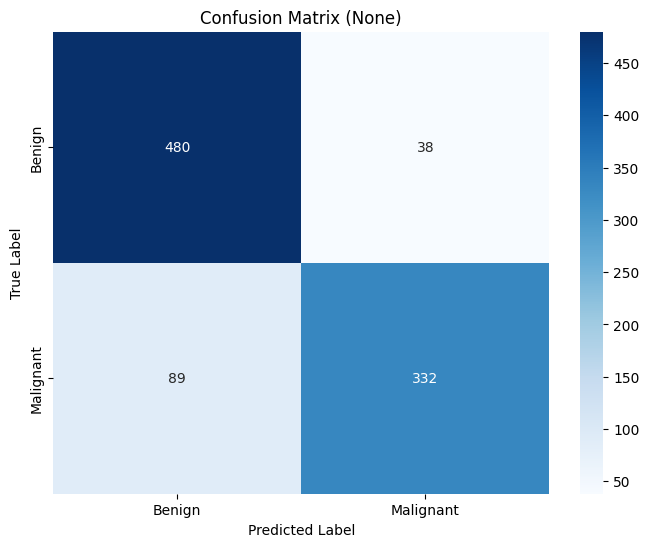

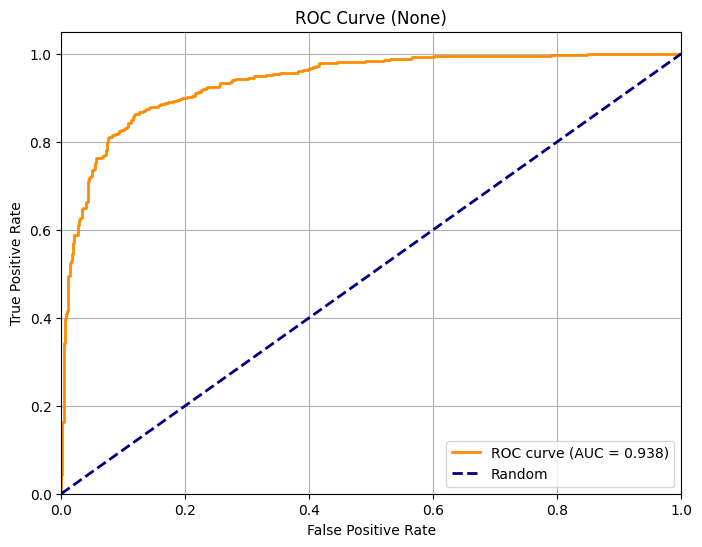

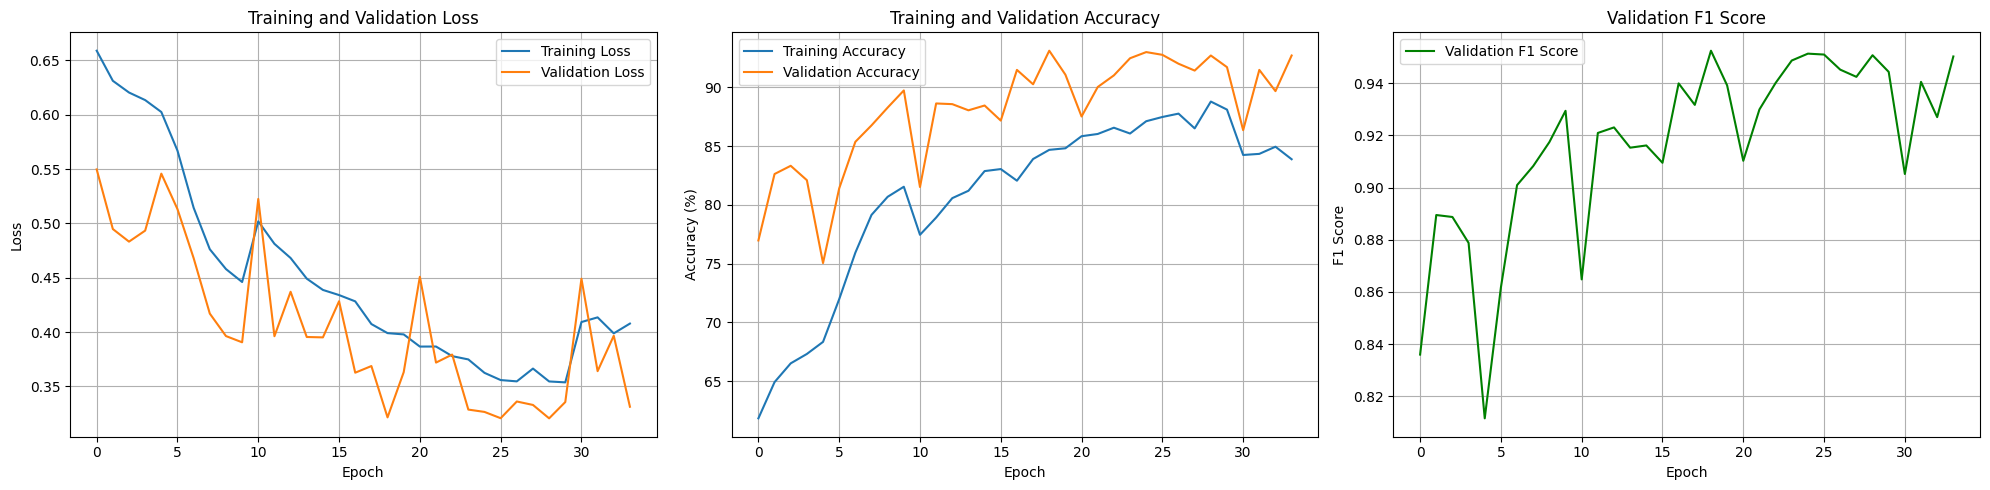


Summary of Metrics for Each Magnification:
Magnification Accuracy Precision Recall Specificity     F1 AUC-ROC
          40X   0.8889    0.8462 0.9252      0.8583 0.8839  0.9450
         100X   0.8941    0.8852 0.8926      0.8955 0.8889  0.9513
         200X   0.8643    0.7928 0.9263      0.8175 0.8544  0.9618
         400X   0.8428    0.7925 0.8571      0.8321 0.8235  0.9156
          All   0.8647    0.8973 0.7886      0.9266 0.8394  0.9379


In [177]:
if __name__ == '__main__':
    df = load_dataset(path)

    # Run experiments for each magnification and combined
    magnifications = ['40X', '100X', '200X', '400X', None]  # None means all magnifications combined

    all_results = []
    for mag in magnifications:
        metrics = run_experiment(df, magnification=mag)
        all_results.append({
            'Magnification': mag if mag else 'All',
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'Specificity': f"{metrics['specificity']:.4f}",
            'F1': f"{metrics['f1']:.4f}",
            'AUC-ROC': f"{metrics['auc_roc']:.4f}"
        })

    # Summary table
    summary_df = pd.DataFrame(all_results)
    print("\nSummary of Metrics for Each Magnification:")
    print(summary_df.to_string(index=False))

    # Optionally save results
    summary_df.to_csv("breakhis_results_summary.csv", index=False)